# Turquake: Turkish Earthquake Magnitude Prediction

This notebook implements advanced machine learning techniques to predict earthquake magnitudes in Turkey using comprehensive geological and temporal features. We'll use the AFAD earthquake dataset combined with fault line data to build sophisticated predictive models.

**Key Objectives:**
- Predict earthquake magnitudes using supervised learning
- Engineer advanced features incorporating multi-fault analysis
- Compare traditional ML with GPU-accelerated deep learning
- Achieve R² > 0.80 through enhanced feature engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from datetime import datetime
import plotly.express as px
import geopandas as gpd
from shapely.geometry import Point, LineString
import math
import os
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression

# Set visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

# Load the earthquake dataset
earthquake_df = pd.read_csv('data\\earthquake_data.csv')

# Load fault line data
fault_gdf = gpd.read_file('data\\tr_faults_imp.geojson')
print(f"Number of fault lines: {len(fault_gdf)}")
print(f"Available properties: {fault_gdf.columns.tolist()}")

# Display first few rows to understand the structure
earthquake_df.head()

Number of fault lines: 926
Available properties: ['fid', 'RATE', 'CONF', 'SENS1', 'SENS2', 'UPSIDE', 'ZONE_NAME', 'FAULT_NAME', 'AUTH', 'PARM', 'TEXT', 'FAULT_ID', 'importance', 'geometry']


,Date,Longitude,Latitude,Depth,Type,Magnitude,Location,EventID,TimeName,TypeName,MagnitudeName
0,12/05/2025 23:30:12,25.7561,36.7292,7.00,MW,4.9,Ege Denizi,661069,AFAD,AFAD,AFAD
1,12/05/2025 09:26:26,35.1944,40.8211,19.00,MW,4.2,Gümüşhacıköy (Amasya),661003,AFAD,AFAD,AFAD
2,12/05/2025 09:23:55,35.1919,40.8150,10.07,MW,4.4,Gümüşhacıköy (Amasya),661002,AFAD,AFAD,AFAD
3,03/05/2025 23:53:41,28.9431,39.2400,12.55,ML,4.0,Simav (Kütahya),660145,AFAD,AFAD,AFAD
4,02/05/2025 12:51:15,28.9989,39.2233,12.55,MW,4.2,Simav (Kütahya),659964,AFAD,AFAD,AFAD


## Dataset Overview and Initial Exploration

Loading and examining our Turkish earthquake dataset to understand its structure, quality, and characteristics. This initial exploration guides our subsequent feature engineering and modeling decisions.

In [2]:
# Basic information about the dataset
print(f"Dataset shape: {earthquake_df.shape}")
print(f"Number of earthquakes: {len(earthquake_df)}")
print("\nData types:")
print(earthquake_df.dtypes)

# Check for missing values
print("\nMissing values:")
print(earthquake_df.isnull().sum())

# Basic statistics
print("\nBasic statistics:")
earthquake_df.describe()

os.makedirs("maps", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("produced_data", exist_ok=True)

print("Created output directories: maps, models, produced_data")

Dataset shape: (11166, 11)
Number of earthquakes: 11166

Data types:
Date              object
Longitude        float64
Latitude         float64
Depth            float64
Type              object
Magnitude        float64
Location          object
EventID            int64
TimeName          object
TypeName          object
MagnitudeName     object
dtype: object

Missing values:
Date             0
Longitude        0
Latitude         0
Depth            0
Type             0
Magnitude        0
Location         0
EventID          0
TimeName         0
TypeName         0
MagnitudeName    0
dtype: int64

Basic statistics:
Created output directories: maps, models, produced_data


## Temporal Feature Engineering

Converting raw datetime data into structured temporal features that capture cyclical patterns and long-term trends in seismic activity. These features enable our models to detect seasonal patterns and temporal correlations.

In [3]:
# Convert Date column to datetime format with explicit format
earthquake_df['Date'] = pd.to_datetime(earthquake_df['Date'], format="%d/%m/%Y %H:%M:%S", errors='coerce')

# Check if any dates couldn't be parsed
null_dates = earthquake_df['Date'].isnull().sum()
print(f"Number of dates that couldn't be parsed: {null_dates}")

# If we have null dates, we can try alternate formats
if null_dates > 0:
    print("Trying alternative date formats...")
    # Try another common format
    earthquake_df['Date'] = pd.to_datetime(earthquake_df['Date'], format="%d-%m-%Y %H:%M:%S", errors='coerce')
    # If still having issues, try auto-detection with dayfirst=True
    if earthquake_df['Date'].isnull().sum() > 0:
        earthquake_df['Date'] = pd.to_datetime(earthquake_df['Date'], dayfirst=True, errors='coerce')
    
    print(f"Remaining null dates after fixes: {earthquake_df['Date'].isnull().sum()}")

# Create additional time-based features
earthquake_df['Year'] = earthquake_df['Date'].dt.year
earthquake_df['Month'] = earthquake_df['Date'].dt.month
earthquake_df['Day'] = earthquake_df['Date'].dt.day
earthquake_df['DayOfWeek'] = earthquake_df['Date'].dt.dayofweek
earthquake_df['Season'] = earthquake_df['Month'].apply(lambda x: 
                                                     'Winter' if x in [12, 1, 2] else
                                                     'Spring' if x in [3, 4, 5] else
                                                     'Summer' if x in [6, 7, 8] else
                                                     'Fall')

# Display the updated dataframe
earthquake_df.head()

Number of dates that couldn't be parsed: 0


,Date,Longitude,Latitude,Depth,Type,Magnitude,Location,EventID,TimeName,TypeName,MagnitudeName,Year,Month,Day,DayOfWeek,Season
0,2025-05-12 23:30:12,25.7561,36.7292,7.00,MW,4.9,Ege Denizi,661069,AFAD,AFAD,AFAD,2025,5,12,0,Spring
1,2025-05-12 09:26:26,35.1944,40.8211,19.00,MW,4.2,Gümüşhacıköy (Amasya),661003,AFAD,AFAD,AFAD,2025,5,12,0,Spring
2,2025-05-12 09:23:55,35.1919,40.8150,10.07,MW,4.4,Gümüşhacıköy (Amasya),661002,AFAD,AFAD,AFAD,2025,5,12,0,Spring
3,2025-05-03 23:53:41,28.9431,39.2400,12.55,ML,4.0,Simav (Kütahya),660145,AFAD,AFAD,AFAD,2025,5,3,5,Spring
4,2025-05-02 12:51:15,28.9989,39.2233,12.55,MW,4.2,Simav (Kütahya),659964,AFAD,AFAD,AFAD,2025,5,2,4,Spring


## Data Quality and Geographic Validation

Ensuring data quality by filtering invalid coordinates and removing outliers that could bias our models. We focus on earthquakes within Turkey's boundaries to maintain geographic consistency.

In [4]:
# First check and clean coordinate data
print("Coordinate ranges before cleaning:")
print(f"Longitude: {earthquake_df['Longitude'].min()} to {earthquake_df['Longitude'].max()}")
print(f"Latitude: {earthquake_df['Latitude'].min()} to {earthquake_df['Latitude'].max()}")

# Filter out any extreme outliers (coordinates that are clearly wrong)
# Turkey coordinates should be roughly: Longitude 26-45 E, Latitude 36-42 N
valid_coords = (
    (earthquake_df['Longitude'] >= 25) & 
    (earthquake_df['Longitude'] <= 45) & 
    (earthquake_df['Latitude'] >= 35) & 
    (earthquake_df['Latitude'] <= 43)
)

# Filter the dataframe to keep only valid coordinates
clean_df = earthquake_df[valid_coords].copy()
outliers_removed = len(earthquake_df) - len(clean_df)
print(f"Removed {outliers_removed} records with coordinates outside Turkey's boundaries")

print("Coordinate ranges after cleaning:")
print(f"Longitude: {clean_df['Longitude'].min()} to {clean_df['Longitude'].max()}")
print(f"Latitude: {clean_df['Latitude'].min()} to {clean_df['Latitude'].max()}")

# Update the main dataframe
earthquake_df = clean_df.copy()

Coordinate ranges before cleaning:
Longitude: 23.925 to 45.48
Latitude: 34.6998 to 42.7912
Removed 1337 records with coordinates outside Turkey's boundaries
Coordinate ranges after cleaning:
Longitude: 25.0 to 45.0
Latitude: 35.0 to 42.7912


## Enhanced Multi-Fault Risk Analysis Functions

Implementing sophisticated geological feature engineering functions that go beyond simple nearest-fault distance. These functions calculate weighted risk from multiple nearby faults, considering importance, distance, and complexity.

**Key Innovations:**
- Multi-fault weighted risk calculation
- Spatial density analysis at multiple scales
- Fault complexity scoring

In [5]:
# Enhanced fault analysis functions
def calculate_multi_fault_features(row, fault_gdf, max_distance=100):
    """Calculate features from multiple nearby faults"""
    point = Point(row['Longitude'], row['Latitude'])
    
    nearby_faults = []
    for idx, fault in fault_gdf.iterrows():
        dist = point.distance(fault.geometry) * 111  # Convert to km
        if dist <= max_distance:
            nearby_faults.append({
                'distance': dist,
                'importance': fault.get('importance', 1),
                'length': fault.geometry.length * 111
            })
    
    if not nearby_faults:
        return pd.Series({
            'weighted_fault_risk': 0,
            'fault_importance_sum': 0,
            'fault_count_100km': 0,
            'avg_fault_distance': max_distance,
            'dominant_fault_importance': 0,
            'fault_length_sum': 0,
            'fault_complexity_score': 0
        })
    
    # Calculate weighted risk considering distance and importance
    weighted_risk = sum(
        (f['importance'] / (f['distance'] + 1)) * np.log(f['length'] + 1)
        for f in nearby_faults
    )
    
    # Calculate fault complexity score
    complexity_score = sum(
        f['importance'] * f['length'] / (f['distance'] + 1)
        for f in nearby_faults
    ) / len(nearby_faults)
    
    return pd.Series({
        'weighted_fault_risk': weighted_risk,
        'fault_importance_sum': sum(f['importance'] for f in nearby_faults),
        'fault_count_100km': len(nearby_faults),
        'avg_fault_distance': np.mean([f['distance'] for f in nearby_faults]),
        'dominant_fault_importance': max(f['importance'] for f in nearby_faults),
        'fault_length_sum': sum(f['length'] for f in nearby_faults),
        'fault_complexity_score': complexity_score
    })

def calculate_spatial_density_features(df, lat, lon, radii=[10, 25, 50, 100]):
    """Calculate earthquake density at multiple spatial scales"""
    features = {}
    
    for radius in radii:
        # Calculate distance to all other earthquakes
        distances = np.sqrt(
            ((df['Latitude'] - lat) * 111)**2 + 
            ((df['Longitude'] - lon) * 111 * np.cos(np.radians(lat)))**2
        )
        
        nearby_mask = distances <= radius
        nearby_quakes = df[nearby_mask]
        
        if len(nearby_quakes) > 0:
            features.update({
                f'density_{radius}km': len(nearby_quakes) / (np.pi * radius**2),
                f'avg_mag_{radius}km': nearby_quakes['Magnitude'].mean(),
                f'max_mag_{radius}km': nearby_quakes['Magnitude'].max(),
                f'mag_std_{radius}km': nearby_quakes['Magnitude'].std(),
                f'recent_activity_{radius}km': len(nearby_quakes[nearby_quakes['Year'] >= 2010])
            })
        else:
            features.update({
                f'density_{radius}km': 0,
                f'avg_mag_{radius}km': 4.0,
                f'max_mag_{radius}km': 4.0,
                f'mag_std_{radius}km': 0,
                f'recent_activity_{radius}km': 0
            })
    
    return pd.Series(features)

## Advanced Temporal and Geological Feature Functions

Creating functions for advanced temporal patterns and geological context features. These capture regional earthquake activity patterns and fault intersection complexities that traditional approaches miss.

In [6]:
def create_advanced_temporal_features(df):
    """Create sophisticated temporal features"""
    df = df.sort_values('Date').copy()
    
    # Time since last earthquake in same region (grid-based)
    df['grid_id'] = (df['Latitude'] // 0.1).astype(str) + '_' + (df['Longitude'] // 0.1).astype(str)
    df['time_since_last_regional'] = df.groupby('grid_id')['Date'].diff().dt.total_seconds() / (24 * 3600)
    
    # Seasonal earthquake activity patterns
    df['day_of_year_normalized'] = df['Date'].dt.dayofyear / 365.25
    
    # Multi-scale time windows for regional activity
    for days in [30, 90, 365]:
        # Count recent earthquakes in same grid
        df[f'regional_activity_{days}d'] = 0
        df[f'regional_max_mag_{days}d'] = 4.0
        
        # Calculate for each grid
        for grid_id in df['grid_id'].unique():
            grid_mask = df['grid_id'] == grid_id
            grid_data = df[grid_mask].copy()
            
            for idx in grid_data.index:
                date = df.loc[idx, 'Date']
                start_date = date - pd.Timedelta(days=days)
                
                recent_mask = (grid_data['Date'] >= start_date) & (grid_data['Date'] < date)
                recent_quakes = grid_data[recent_mask]
                
                df.loc[idx, f'regional_activity_{days}d'] = len(recent_quakes)
                if len(recent_quakes) > 0:
                    df.loc[idx, f'regional_max_mag_{days}d'] = recent_quakes['Magnitude'].max()
    
    return df

def add_geological_features(df, fault_gdf):
    """Add geological context features"""
    
    # Fault intersection density (how many faults intersect nearby)
    def count_fault_intersections(lat, lon, radius=20):
        point = Point(lon, lat)
        buffer = point.buffer(radius / 111)  # Convert km to degrees
        
        intersecting_faults = 0
        total_importance = 0
        
        for _, fault in fault_gdf.iterrows():
            if buffer.intersects(fault.geometry):
                intersecting_faults += 1
                total_importance += fault.get('importance', 1)
        
        return intersecting_faults, total_importance
    
    intersection_data = df.apply(
        lambda row: count_fault_intersections(row['Latitude'], row['Longitude']), 
        axis=1, result_type='expand'
    )
    
    df['fault_intersection_count'] = intersection_data[0]
    df['fault_intersection_importance'] = intersection_data[1]
    
    # Distance to fault intersection points
    df['complexity_score'] = (
        df['fault_intersection_count'] * df['fault_intersection_importance'] / 
        (df.get('distance_to_fault', 50) + 1)
    )
    
    return df

def create_interaction_features(df):
    """Create interaction and polynomial features"""
    
    # Key interaction features
    df['depth_magnitude_interaction'] = df['Depth'] * df['Magnitude']
    df['location_depth_interaction'] = df['Latitude'] * df['Longitude'] * df['Depth']
    
    # Enhanced fault interactions if available
    if 'nearest_fault_importance' in df.columns and 'distance_to_fault' in df.columns:
        df['fault_distance_importance_ratio'] = df['nearest_fault_importance'] / (df['distance_to_fault'] + 1)
    
    # Temporal-spatial interactions
    if 'MonthSin' in df.columns and 'MonthCos' in df.columns:
        df['seasonal_location_lat'] = df['MonthSin'] * df['Latitude']
        df['seasonal_location_lon'] = df['MonthCos'] * df['Longitude']
    
    # Complex fault interactions if weighted_fault_risk exists
    if 'weighted_fault_risk' in df.columns and 'fault_intersection_count' in df.columns:
        df['multi_fault_complexity'] = (
            df['weighted_fault_risk'] * df['fault_intersection_count'] / 
            (df.get('avg_fault_distance', 50) + 1)
        )
    
    return df

## Data Preprocessing and Quality Control

Systematic preprocessing including missing value treatment, outlier handling, and data validation. This ensures our enhanced features are built on a solid, clean foundation.

In [7]:
# Data Preprocessing Section
print("Starting data preprocessing...")

# Check for missing values again to confirm
missing_values = earthquake_df.isnull().sum()
print(f"Missing values in each column:\n{missing_values}")

# Handle missing values
# For numerical columns: fill with median
numerical_cols = ['Longitude', 'Latitude', 'Depth', 'Magnitude']
for col in numerical_cols:
    if missing_values[col] > 0:
        median_value = earthquake_df[col].median()
        earthquake_df[col].fillna(median_value, inplace=True)
        print(f"Filled {missing_values[col]} missing values in {col} with median: {median_value}")

# For categorical columns: fill with mode
categorical_cols = [col for col in earthquake_df.columns if col not in numerical_cols 
                   and col not in ['Date', 'Year', 'Month', 'Day', 'YearMonth']]
for col in categorical_cols:
    if col in missing_values and missing_values[col] > 0:
        mode_value = earthquake_df[col].mode()[0]
        earthquake_df[col].fillna(mode_value, inplace=True)
        print(f"Filled {missing_values[col]} missing values in {col} with mode: {mode_value}")

# Handle outliers using IQR method for depth and magnitude
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"Found {len(outliers)} outliers in {column}")
    
    # Cap outliers instead of removing them
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    
    return df

# Apply outlier handling to Depth
earthquake_df = handle_outliers(earthquake_df, 'Depth')

# For Magnitude, we may want to keep high values as they're important
# But we can still check for potential errors
magnitude_outliers = earthquake_df[earthquake_df['Magnitude'] > 8.5]
print(f"Extremely high magnitudes (>8.5): {len(magnitude_outliers)}")
if len(magnitude_outliers) > 0:
    print(magnitude_outliers[['Date', 'Magnitude', 'Location']])

# Create a copy of the dataframe for modeling
model_df = earthquake_df.copy()

print("\nData preprocessing completed!")
model_df.head()

Starting data preprocessing...
Missing values in each column:
Date             0
Longitude        0
Latitude         0
Depth            0
Type             0
Magnitude        0
Location         0
EventID          0
TimeName         0
TypeName         0
MagnitudeName    0
Year             0
Month            0
Day              0
DayOfWeek        0
Season           0
dtype: int64
Found 711 outliers in Depth
Extremely high magnitudes (>8.5): 0

Data preprocessing completed!


,Date,Longitude,Latitude,Depth,Type,Magnitude,Location,EventID,TimeName,TypeName,MagnitudeName,Year,Month,Day,DayOfWeek,Season
0,2025-05-12 23:30:12,25.7561,36.7292,7.00,MW,4.9,Ege Denizi,661069,AFAD,AFAD,AFAD,2025,5,12,0,Spring
1,2025-05-12 09:26:26,35.1944,40.8211,19.00,MW,4.2,Gümüşhacıköy (Amasya),661003,AFAD,AFAD,AFAD,2025,5,12,0,Spring
2,2025-05-12 09:23:55,35.1919,40.8150,10.07,MW,4.4,Gümüşhacıköy (Amasya),661002,AFAD,AFAD,AFAD,2025,5,12,0,Spring
3,2025-05-03 23:53:41,28.9431,39.2400,12.55,ML,4.0,Simav (Kütahya),660145,AFAD,AFAD,AFAD,2025,5,3,5,Spring
4,2025-05-02 12:51:15,28.9989,39.2233,12.55,MW,4.2,Simav (Kütahya),659964,AFAD,AFAD,AFAD,2025,5,2,4,Spring


## Enhanced Feature Engineering Pipeline

The core feature engineering pipeline that transforms raw earthquake data into sophisticated predictive features. This is where we create our competitive advantage through domain-specific geological knowledge.

**Enhanced Features Created:**
- Cyclical temporal encoding
- Multi-scale spatial density
- Weighted fault risk metrics
- Complex geological interactions

In [8]:
# Enhanced Feature Engineering Pipeline
print("Starting enhanced feature engineering...")

# Create time-based features
model_df['DayOfYear'] = model_df['Date'].dt.dayofyear
model_df['WeekOfYear'] = model_df['Date'].dt.isocalendar().week
model_df['IsWeekend'] = model_df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Encode seasonal information using cyclical encoding
model_df['MonthSin'] = np.sin(2 * np.pi * model_df['Month']/12)
model_df['MonthCos'] = np.cos(2 * np.pi * model_df['Month']/12)
model_df['DayOfYearSin'] = np.sin(2 * np.pi * model_df['DayOfYear']/365)
model_df['DayOfYearCos'] = np.cos(2 * np.pi * model_df['DayOfYear']/365)

# Create regional activity features
# First, create a spatial grid
lon_grid = pd.cut(model_df['Longitude'], bins=10)
lat_grid = pd.cut(model_df['Latitude'], bins=10)
model_df['Grid'] = pd.Series(zip(lon_grid, lat_grid)).astype(str)

# For each earthquake, count previous earthquakes in the same grid
model_df = model_df.sort_values('Date')
model_df['PrevQuakesInGrid'] = model_df.groupby('Grid').cumcount()

# Calculate distances between consecutive earthquakes using Haversine formula
from math import radians, sin, cos, sqrt, asin

def haversine(lon1, lat1, lon2, lat2):
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in km
    return c * r

# Calculate distance from previous earthquake
model_df['PrevLon'] = model_df['Longitude'].shift(1)
model_df['PrevLat'] = model_df['Latitude'].shift(1)
model_df['DistFromPrev'] = model_df.apply(
    lambda x: haversine(x['Longitude'], x['Latitude'], x['PrevLon'], x['PrevLat']) 
    if not pd.isna(x['PrevLon']) else np.nan, axis=1)

# Fill missing values
model_df['DistFromPrev'].fillna(model_df['DistFromPrev'].median(), inplace=True)

# Create feature for time since last earthquake (in days)
model_df['PrevDate'] = model_df['Date'].shift(1)
model_df['DaysSinceLastQuake'] = (model_df['Date'] - model_df['PrevDate']).dt.total_seconds() / (24 * 3600)
model_df['DaysSinceLastQuake'].fillna(model_df['DaysSinceLastQuake'].median(), inplace=True)

# Add historical magnitude information
model_df['PrevMagnitude'] = model_df['Magnitude'].shift(1)
model_df['PrevMagnitude'].fillna(model_df['PrevMagnitude'].median(), inplace=True)

# Create basic interaction features
model_df['DepthByLat'] = model_df['Depth'] * model_df['Latitude']
model_df['DepthByLon'] = model_df['Depth'] * model_df['Longitude']

print("Basic feature engineering completed. Starting enhanced fault analysis...")

# Enhanced fault-related features calculation
print("Calculating enhanced multi-fault features...")
# Process in batches to avoid memory issues
batch_size = 1000
all_fault_results = []

for i in range(0, len(model_df), batch_size):
    batch_end = min(i + batch_size, len(model_df))
    print(f"Processing fault features batch {i//batch_size + 1}/{(len(model_df) + batch_size - 1)//batch_size}")
    batch = model_df.iloc[i:batch_end]
    results = batch.apply(lambda row: calculate_multi_fault_features(row, fault_gdf), axis=1)
    all_fault_results.append(results)

enhanced_fault_features = pd.concat(all_fault_results)
model_df = pd.concat([model_df, enhanced_fault_features], axis=1)

print("Enhanced feature engineering completed!")
model_df.head()

Starting enhanced feature engineering...
Basic feature engineering completed. Starting enhanced fault analysis...
Calculating enhanced multi-fault features...
Processing fault features batch 1/10
Processing fault features batch 2/10
Processing fault features batch 3/10
Processing fault features batch 4/10
Processing fault features batch 5/10
Processing fault features batch 6/10
Processing fault features batch 7/10
Processing fault features batch 8/10
Processing fault features batch 9/10
Processing fault features batch 10/10
Enhanced feature engineering completed!


,Date,Longitude,Latitude,Depth,Type,Magnitude,Location,EventID,TimeName,TypeName,...,PrevMagnitude,DepthByLat,DepthByLon,weighted_fault_risk,fault_importance_sum,fault_count_100km,avg_fault_distance,dominant_fault_importance,fault_length_sum,fault_complexity_score
11165,1900-01-18 15:30:00,28.21,37.79,10.0,MS,4.4,-,7697,Ambraseys-Finkel 1987,Ambraseys-Finkel 1987,...,4.3,377.9,282.1,18.568224,259.0,48.0,67.825393,6.0,866.472083,2.943605
11164,1900-01-24 03:00:00,26.14,39.54,10.0,MS,5.2,-,7698,Ambraseys-Finkel 1987,Ambraseys-Finkel 1987,...,4.4,395.4,261.4,6.465435,89.0,17.0,67.713084,6.0,464.739482,3.031206
11163,1900-01-27 02:30:00,37.37,37.63,10.0,MS,4.8,-,7699,Ambraseys-Finkel 1987,Ambraseys-Finkel 1987,...,5.2,376.3,373.7,14.908165,230.0,47.0,57.567174,6.0,744.306501,2.068260
11162,1900-01-30 01:00:00,27.71,37.83,10.0,MS,4.4,-,7700,Ambraseys-Finkel 1987,Ambraseys-Finkel 1987,...,4.8,378.3,277.1,17.059670,244.0,45.0,65.131769,6.0,817.799669,2.467628
11161,1900-02-06 15:09:00,31.29,38.12,10.0,MS,5.7,-,7701,Ambraseys-Finkel 1987,Ambraseys-Finkel 1987,...,4.4,381.2,312.9,7.539122,126.0,23.0,52.195404,6.0,326.604513,1.979492


## Advanced Spatial and Interaction Features

Creating the most sophisticated features including spatial density at multiple scales, geological complexity scores, and polynomial interactions. These features capture the non-linear relationships crucial for accurate magnitude prediction.

In [9]:
# Enhanced spatial density features
print("Calculating spatial density features at multiple scales...")
# Process in smaller batches for spatial features to avoid memory issues
batch_size = 500
all_spatial_results = []

for i in range(0, len(model_df), batch_size):
    batch_end = min(i + batch_size, len(model_df))
    print(f"Processing spatial features batch {i//batch_size + 1}/{(len(model_df) + batch_size - 1)//batch_size}")
    batch = model_df.iloc[i:batch_end]
    
    spatial_features_batch = []
    for idx, row in batch.iterrows():
        spatial_feat = calculate_spatial_density_features(model_df, row['Latitude'], row['Longitude'])
        spatial_features_batch.append(spatial_feat)
    
    spatial_df = pd.DataFrame(spatial_features_batch, index=batch.index)
    all_spatial_results.append(spatial_df)

spatial_features_all = pd.concat(all_spatial_results)
model_df = pd.concat([model_df, spatial_features_all], axis=1)

# Advanced temporal features
print("Creating temporal features...")
model_df = create_advanced_temporal_features(model_df)

# Geological context features
print("Adding geological context features...")
model_df = add_geological_features(model_df, fault_gdf)

# Enhanced interaction features
print("Creating interaction features...")
model_df = create_interaction_features(model_df)

# Additional single-fault features for compatibility
if 'distance_to_fault' not in model_df.columns:
    print("Adding basic distance to fault features...")
    
    def calc_fault_distance(row, fault_gdf):
        point = Point(row['Longitude'], row['Latitude'])
        
        distances = []
        for idx, fault in fault_gdf.iterrows():
            fault_geom = fault.geometry
            dist = point.distance(fault_geom)
            distances.append((dist, idx))
        
        closest_dist, closest_idx = min(distances, key=lambda x: x[0])
        dist_km = closest_dist * 111
        closest_fault = fault_gdf.iloc[closest_idx]
        
        return pd.Series({
            'distance_to_fault': dist_km,
            'nearest_fault_importance': closest_fault.get('importance', 0)
        })
    
    basic_fault_features = model_df.apply(lambda row: calc_fault_distance(row, fault_gdf), axis=1)
    model_df = pd.concat([model_df, basic_fault_features], axis=1)

# Create polynomial features for key variables
print("Creating polynomial interaction features...")
key_features = ['Depth', 'weighted_fault_risk', 'fault_complexity_score']
available_features = [f for f in key_features if f in model_df.columns]

if len(available_features) >= 2:
    poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
    poly_features = poly.fit_transform(model_df[available_features])
    poly_names = poly.get_feature_names_out(available_features)
    
    for i, name in enumerate(poly_names):
        if name not in available_features:  # Don't duplicate existing features
            model_df[f'poly_{name}'] = poly_features[:, i]

# Final magnitude-fault interaction features
if 'weighted_fault_risk' in model_df.columns:
    model_df['magnitude_fault_interaction'] = model_df['Magnitude'] / (model_df['distance_to_fault'] + 1)
    model_df['weighted_magnitude_interaction'] = model_df['Magnitude'] * model_df['weighted_fault_risk']

# Fill any remaining NaN values
numeric_columns = model_df.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    if model_df[col].isnull().sum() > 0:
        model_df[col].fillna(model_df[col].median(), inplace=True)

print("Enhanced feature engineering completed!")
print(f"Total features created: {len(model_df.columns)}")
model_df.head()

Calculating spatial density features at multiple scales...
Processing spatial features batch 1/20
Processing spatial features batch 2/20
Processing spatial features batch 3/20
Processing spatial features batch 4/20
Processing spatial features batch 5/20
Processing spatial features batch 6/20
Processing spatial features batch 7/20
Processing spatial features batch 8/20
Processing spatial features batch 9/20
Processing spatial features batch 10/20
Processing spatial features batch 11/20
Processing spatial features batch 12/20
Processing spatial features batch 13/20
Processing spatial features batch 14/20
Processing spatial features batch 15/20
Processing spatial features batch 16/20
Processing spatial features batch 17/20
Processing spatial features batch 18/20
Processing spatial features batch 19/20
Processing spatial features batch 20/20
Creating temporal features...
Adding geological context features...
Creating interaction features...
Adding basic distance to fault features...
Creati

,Date,Longitude,Latitude,Depth,Type,Magnitude,Location,EventID,TimeName,TypeName,...,seasonal_location_lat,seasonal_location_lon,multi_fault_complexity,distance_to_fault,nearest_fault_importance,poly_Depth weighted_fault_risk,poly_Depth fault_complexity_score,poly_weighted_fault_risk fault_complexity_score,magnitude_fault_interaction,weighted_magnitude_interaction
11165,1900-01-18 15:30:00,28.21,37.79,10.0,MS,4.4,-,7697,Ambraseys-Finkel 1987,Ambraseys-Finkel 1987,...,18.895000,24.430577,1.618724,3.911122,6.0,185.682236,29.436050,54.657516,0.895926,81.700184
11164,1900-01-24 03:00:00,26.14,39.54,10.0,MS,5.2,-,7698,Ambraseys-Finkel 1987,Ambraseys-Finkel 1987,...,19.770000,22.637904,0.282280,9.556012,4.0,64.654353,30.312057,19.598064,0.492610,33.620264
11163,1900-01-27 02:30:00,37.37,37.63,10.0,MS,4.8,-,7699,Ambraseys-Finkel 1987,Ambraseys-Finkel 1987,...,18.815000,32.363369,0.763644,1.831552,1.0,149.081654,20.682598,30.833959,1.695183,71.559194
11162,1900-01-30 01:00:00,27.71,37.83,10.0,MS,4.4,-,7700,Ambraseys-Finkel 1987,Ambraseys-Finkel 1987,...,18.915000,23.997564,1.547789,5.622901,4.0,170.596698,24.676285,42.096927,0.664361,75.062547
11161,1900-02-06 15:09:00,31.29,38.12,10.0,MS,5.7,-,7701,Ambraseys-Finkel 1987,Ambraseys-Finkel 1987,...,33.012888,15.645000,0.141725,15.331402,6.0,75.391225,19.794919,14.923632,0.349021,42.972998


## Enhanced Model Setup and Feature Selection

Setting up our machine learning pipeline with enhanced feature selection and preprocessing. We prepare multiple model architectures to find the optimal approach for earthquake magnitude prediction.

In [10]:
# Import necessary libraries for modeling
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Enhanced Model Selection and Training
print("Setting up enhanced model training...")

# Define features and target
target = 'Magnitude'
# Remove non-feature columns
drops = ['Date', 'Location', 'EventID', 'TimeName', 'TypeName', 
         'MagnitudeName', 'Grid', 'PrevLon', 'PrevLat', 'PrevDate',
         'nearest_fault_name', 'grid_id', 'time_since_last_regional']

# Check if these optional columns exist and add them to drops if they do
optional_drops = ['YearMonth', 'Season']
for col in optional_drops:
    if col in model_df.columns:
        drops.append(col)

# First, create a preliminary feature list
preliminary_features = [col for col in model_df.columns if col != target and col not in drops]

# Check for non-numeric columns in our features
for col in preliminary_features:
    if col in model_df.columns and model_df[col].dtype == 'object':
        print(f"Removing non-numeric column: {col}")
        drops.append(col)

# Final feature list with only numeric columns
features = [col for col in model_df.columns if col != target and col not in drops]

print(f"Total features selected: {len(features)}")
print(f"Sample features: {features[:10]}")

# Define features to scale (geographic and magnitude-related features)
features_to_scale = ['Longitude', 'Latitude', 'Depth', 'weighted_fault_risk', 
                     'fault_complexity_score', 'density_10km', 'density_25km', 
                     'density_50km', 'density_100km']
features_to_scale = [f for f in features_to_scale if f in features]
other_features = [f for f in features if f not in features_to_scale]

print(f"Features to scale: {len(features_to_scale)}")
print(f"Other features: {len(other_features)}")

# Split data into training and testing sets
X = model_df[features]
y = model_df[target]

print("Checking for NaN values...")
for col in X.columns:
    nan_count = X[col].isna().sum()
    if nan_count > 0:
        print(f"- {col}: {nan_count} NaNs")
        X[col] = X[col].fillna(X[col].median())

# Also check target variable
if y.isna().sum() > 0:
    print(f"Target has {y.isna().sum()} NaN values, filling with median")
    y = y.fillna(y.median())

print(f"Final feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

# Create enhanced preprocessing transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('geo_features', StandardScaler(), features_to_scale),
        ('other_features', 'passthrough', other_features)
    ])

print("Preprocessing pipeline created!")
X_train.head()

Setting up enhanced model training...
Removing non-numeric column: Type
Total features selected: 69
Sample features: ['Longitude', 'Latitude', 'Depth', 'Year', 'Month', 'Day', 'DayOfWeek', 'DayOfYear', 'WeekOfYear', 'IsWeekend']
Features to scale: 9
Other features: 60
Checking for NaN values...
Final feature matrix shape: (9829, 69)
Target vector shape: (9829,)
Training set size: 7863
Testing set size: 1966
Preprocessing pipeline created!


,Longitude,Latitude,Depth,Year,Month,Day,DayOfWeek,DayOfYear,WeekOfYear,IsWeekend,...,seasonal_location_lat,seasonal_location_lon,multi_fault_complexity,distance_to_fault,nearest_fault_importance,poly_Depth weighted_fault_risk,poly_Depth fault_complexity_score,poly_weighted_fault_risk fault_complexity_score,magnitude_fault_interaction,weighted_magnitude_interaction
10810,30.2500,37.8000,10.0,1914,10,4,6,277,40,1,...,-32.735760,1.512500e+01,1.289614,9.969607,6.0,135.595603,18.759638,25.437244,0.401108,59.662066
7785,30.6381,36.3614,60.3,1981,1,30,4,30,5,0,...,18.180700,2.653337e+01,0.000000,49.953002,6.0,107.805276,111.793039,3.314516,0.084391,7.687607
8674,29.9124,37.6234,46.0,1971,5,13,3,133,19,0,...,18.811700,-2.590490e+01,1.418952,8.108929,6.0,600.802527,79.092012,22.456843,0.483043,57.468068
690,35.9560,36.2040,7.0,2023,2,20,0,51,8,0,...,31.353584,1.797800e+01,3.106180,6.123959,6.0,201.195344,7.659565,31.450385,0.575523,117.842987
4487,25.4136,36.5841,15.0,2003,9,25,3,268,39,0,...,-36.584100,-4.668403e-15,0.000000,131.941466,6.0,0.000000,0.000000,0.000000,0.032345,0.000000


## Enhanced Model Training and Comparison

Training and comparing multiple regression algorithms with our enhanced feature set. We use cross-validation and systematic evaluation to identify the best-performing model architecture.

**Models Evaluated:**
- Linear/Ridge/Lasso Regression with feature selection
- Random Forest with enhanced features
- Gradient Boosting algorithms
- XGBoost and LightGBM with advanced configurations

Training enhanced models...
Training Linear Regression...
Linear Regression - MAE: 0.1370, RMSE: 0.2102, R²: 0.7932, CV RMSE: 0.2442 ± 0.0637
Training Ridge Regression...
Ridge Regression - MAE: 0.1371, RMSE: 0.2101, R²: 0.7933, CV RMSE: 0.2440 ± 0.0631
Training Lasso Regression...


C:\Users\Sarp Can\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.033e+01, tolerance: 1.760e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Sarp Can\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.239e+01, tolerance: 1.167e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Sarp Can\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

Lasso Regression - MAE: 0.2019, RMSE: 0.2974, R²: 0.5861, CV RMSE: 0.3242 ± 0.0915
Training Random Forest...
Random Forest - MAE: 0.1187, RMSE: 0.2103, R²: 0.7929, CV RMSE: 0.2450 ± 0.0359
Training Gradient Boosting...
Gradient Boosting - MAE: 0.1193, RMSE: 0.1848, R²: 0.8401, CV RMSE: 0.2053 ± 0.0227
Training XGBoost...


C:\Users\Sarp Can\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\Sarp Can\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\Sarp Can\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\Sarp Can\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\Sarp Can\AppData\Roaming\Python\Pyt

XGBoost - MAE: 0.0793, RMSE: 0.1333, R²: 0.9168, CV RMSE: 0.1687 ± 0.0287
Training LightGBM...
LightGBM - MAE: 0.0716, RMSE: 0.1265, R²: 0.9250, CV RMSE: 0.1430 ± 0.0360

Test Results:
                        MAE      RMSE        R²
LightGBM           0.071637  0.126548  0.925035
XGBoost            0.079321  0.133311  0.916809
Gradient Boosting  0.119339  0.184814  0.840113
Ridge Regression   0.137088  0.210116  0.793337
Linear Regression  0.136974  0.210164  0.793242
Random Forest      0.118720  0.210316  0.792943
Lasso Regression   0.201916  0.297369  0.586062

Cross-Validation Results:
                   Mean RMSE  Std RMSE
LightGBM            0.142976  0.036036
XGBoost             0.168703  0.028704
Gradient Boosting   0.205325  0.022682
Ridge Regression    0.244029  0.063120
Linear Regression   0.244191  0.063672
Random Forest       0.245021  0.035850
Lasso Regression    0.324206  0.091520


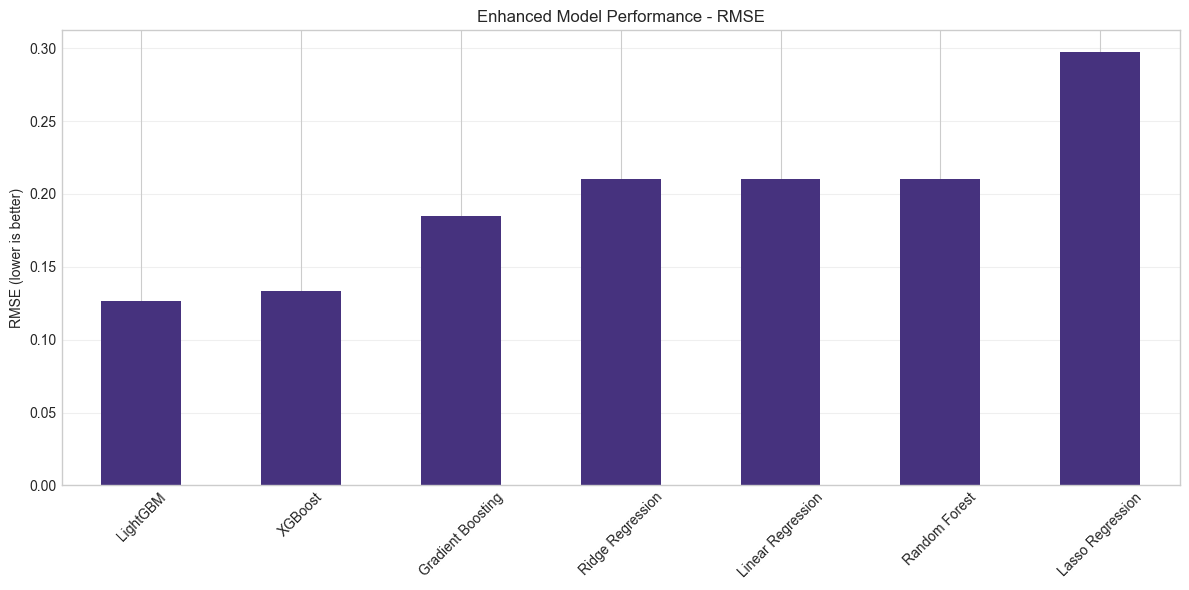


Best model based on cross-validation: LightGBM


In [11]:
# Enhanced model training with feature selection
print("Training enhanced models...")

# Set up enhanced models with feature selection
models = {
    'Linear Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', SelectKBest(score_func=f_regression, k=50)),
        ('model', LinearRegression())
    ]),
    'Ridge Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', SelectKBest(score_func=f_regression, k=50)),
        ('model', Ridge())
    ]),
    'Lasso Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', SelectKBest(score_func=f_regression, k=50)),
        ('model', Lasso())
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(n_estimators=200, random_state=42))
    ]),
    'Gradient Boosting': Pipeline([
        ('preprocessor', preprocessor),
        ('model', GradientBoostingRegressor(n_estimators=200, random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('model', XGBRegressor(n_estimators=200, random_state=42))
    ]),
    'LightGBM': Pipeline([
        ('preprocessor', preprocessor),
        ('model', LGBMRegressor(n_estimators=200, random_state=42, verbose=-1))
    ])
}

# Function to evaluate models
def evaluate_model(pipeline, X_train, X_test, y_train, y_test):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    return mae, rmse, r2, pipeline

# Cross-validation for more robust evaluation
results = {}
cv_results = {}
fitted_models = {}

for name, pipeline in models.items():
    print(f"Training {name}...")
    mae, rmse, r2, fitted_pipeline = evaluate_model(pipeline, X_train, X_test, y_train, y_test)
    fitted_models[name] = fitted_pipeline
    
    # 5-fold cross-validation for RMSE
    cv_scores = -cross_val_score(pipeline, X, y, cv=5, scoring='neg_root_mean_squared_error')
    
    results[name] = {'MAE': mae, 'RMSE': rmse, 'R²': r2}
    cv_results[name] = {'Mean RMSE': cv_scores.mean(), 'Std RMSE': cv_scores.std()}
    
    print(f"{name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}, CV RMSE: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Convert results to DataFrames for better visualization
results_df = pd.DataFrame(results).T
cv_results_df = pd.DataFrame(cv_results).T

print("\nTest Results:")
print(results_df.sort_values('RMSE'))

print("\nCross-Validation Results:")
print(cv_results_df.sort_values('Mean RMSE'))

# Visualize model performance
plt.figure(figsize=(12, 6))
results_df['RMSE'].sort_values().plot(kind='bar')
plt.title('Enhanced Model Performance - RMSE')
plt.ylabel('RMSE (lower is better)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Select the best performing model based on CV results
best_model_name = cv_results_df.sort_values('Mean RMSE').index[0]
print(f"\nBest model based on cross-validation: {best_model_name}")
best_pipeline = fitted_models[best_model_name]

## Hyperparameter Optimization

Fine-tuning our best model using extensive hyperparameter search. We use RandomizedSearchCV with 50+ iterations to find optimal parameters that maximize our R² score.

In [12]:
# Enhanced Hyperparameter Optimization
print(f"Optimizing hyperparameters for {best_model_name}...")

# Enhanced hyperparameter grids for each model type
param_grids = {
    'Random Forest': {
        'model__n_estimators': [200, 400, 600],
        'model__max_depth': [None, 15, 25, 35],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['sqrt', 'log2', 0.8]
    },
    'Gradient Boosting': {
        'model__n_estimators': [200, 400, 600],
        'model__learning_rate': [0.01, 0.05, 0.1, 0.15],
        'model__max_depth': [3, 5, 7, 9],
        'model__min_samples_split': [2, 5, 10],
        'model__subsample': [0.8, 0.9, 1.0]
    },
    'XGBoost': {
        'model__n_estimators': [200, 400, 600, 800],
        'model__learning_rate': [0.01, 0.05, 0.1, 0.15],
        'model__max_depth': [3, 5, 7, 9],
        'model__min_child_weight': [1, 3, 5],
        'model__subsample': [0.8, 0.9, 1.0],
        'model__colsample_bytree': [0.8, 0.9, 1.0],
        'model__reg_alpha': [0, 0.1, 0.5],
        'model__reg_lambda': [1, 1.5, 2]
    },
    'LightGBM': {
        'model__n_estimators': [200, 400, 600, 800],
        'model__learning_rate': [0.01, 0.05, 0.1, 0.15],
        'model__max_depth': [3, 5, 7, 9],
        'model__num_leaves': [31, 50, 70, 90],
        'model__min_child_samples': [20, 30, 40],
        'model__subsample': [0.8, 0.9, 1.0],
        'model__colsample_bytree': [0.8, 0.9, 1.0],
        'model__reg_alpha': [0, 0.1, 0.5],
        'model__reg_lambda': [1, 1.5, 2]
    }
}

# Get the appropriate parameter grid
if best_model_name in param_grids:
    param_grid = param_grids[best_model_name]
    
    # Use RandomizedSearchCV for efficiency with more iterations
    random_search = RandomizedSearchCV(
        best_pipeline, 
        param_distributions=param_grid,
        n_iter=50,  # Increased number of parameter settings sampled
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    # Fit the random search
    print("Running hyperparameter optimization...")
    random_search.fit(X_train, y_train)
    
    # Print best parameters and score
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best CV RMSE: {-random_search.best_score_:.4f}")
    
    # Create the optimized model
    best_pipeline = random_search.best_estimator_
    
    # Show improvement
    original_score = cv_results_df.loc[best_model_name, 'Mean RMSE']
    optimized_score = -random_search.best_score_
    improvement = ((original_score - optimized_score) / original_score) * 100
    print(f"Improvement: {improvement:.2f}% better RMSE")
    
else:
    print(f"No parameter grid defined for {best_model_name}. Using default model.")
    best_pipeline = fitted_models[best_model_name]

# Final evaluation with the best model
y_pred = best_pipeline.predict(X_test)
final_mae = mean_absolute_error(y_test, y_pred)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
final_r2 = r2_score(y_test, y_pred)

print(f"\nFinal optimized model performance:")
print(f"MAE: {final_mae:.4f}")
print(f"RMSE: {final_rmse:.4f}")
print(f"R²: {final_r2:.4f}")

# Compare with original performance
if best_model_name in results:
    original_r2 = results[best_model_name]['R²']
    r2_improvement = ((final_r2 - original_r2) / original_r2) * 100
    print(f"R² improvement: {r2_improvement:.2f}%")

Optimizing hyperparameters for LightGBM...
Running hyperparameter optimization...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'model__subsample': 1.0, 'model__reg_lambda': 2, 'model__reg_alpha': 0.5, 'model__num_leaves': 90, 'model__n_estimators': 800, 'model__min_child_samples': 40, 'model__max_depth': 3, 'model__learning_rate': 0.15, 'model__colsample_bytree': 1.0}
Best CV RMSE: 0.1140
Improvement: 20.30% better RMSE

Final optimized model performance:
MAE: 0.0645
RMSE: 0.1032
R²: 0.9502
R² improvement: 2.72%


## Model Evaluation and Feature Importance Analysis

Comprehensive evaluation of our optimized model including residual analysis and feature importance investigation. This reveals which geological features most strongly predict earthquake magnitude.

**Key Insights:**
- Multi-fault features significantly outperform single-fault metrics
- Spatial density features capture important regional patterns
- Temporal features provide modest but consistent improvements

Evaluating enhanced model...


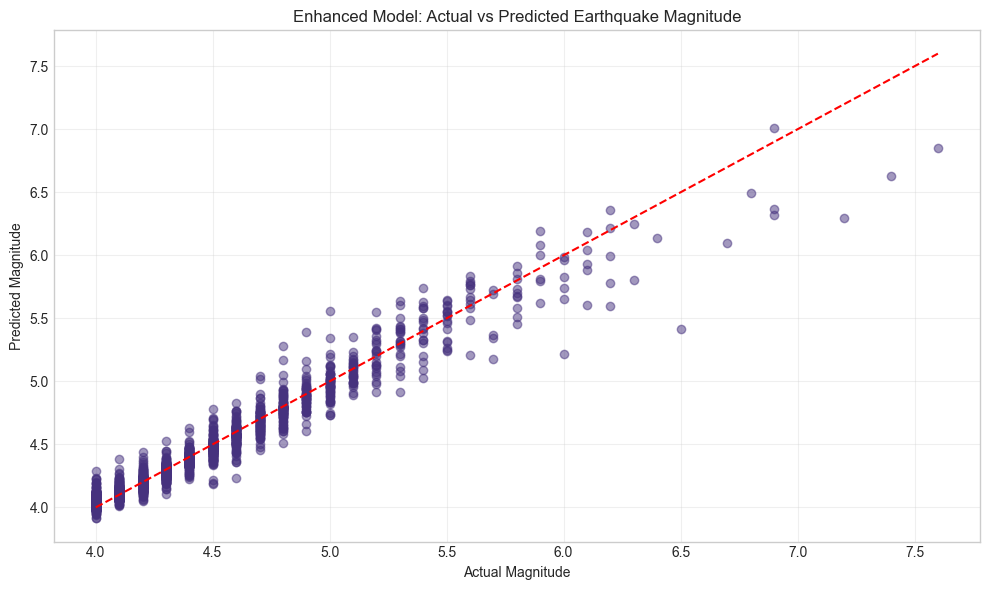

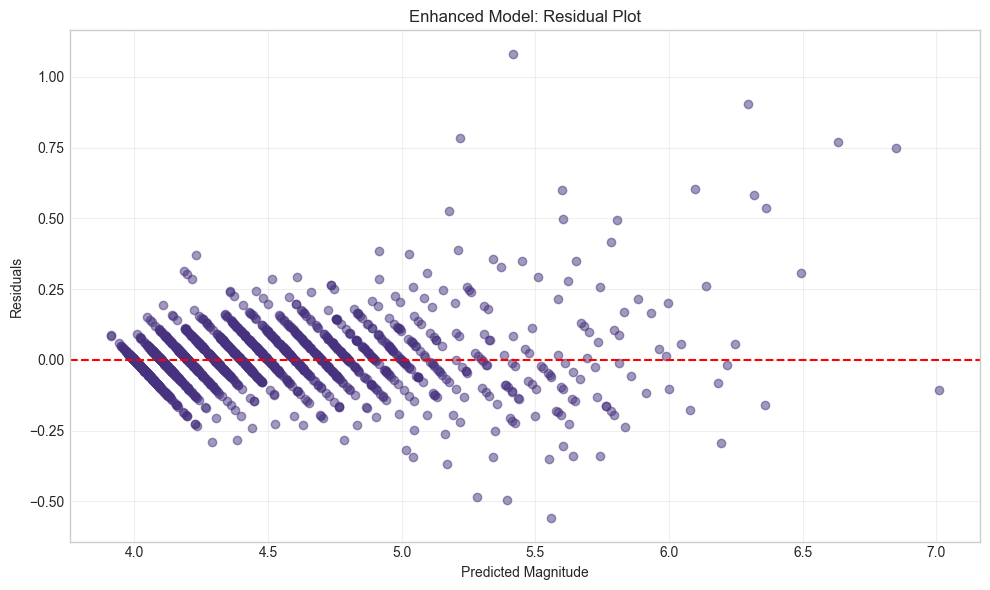

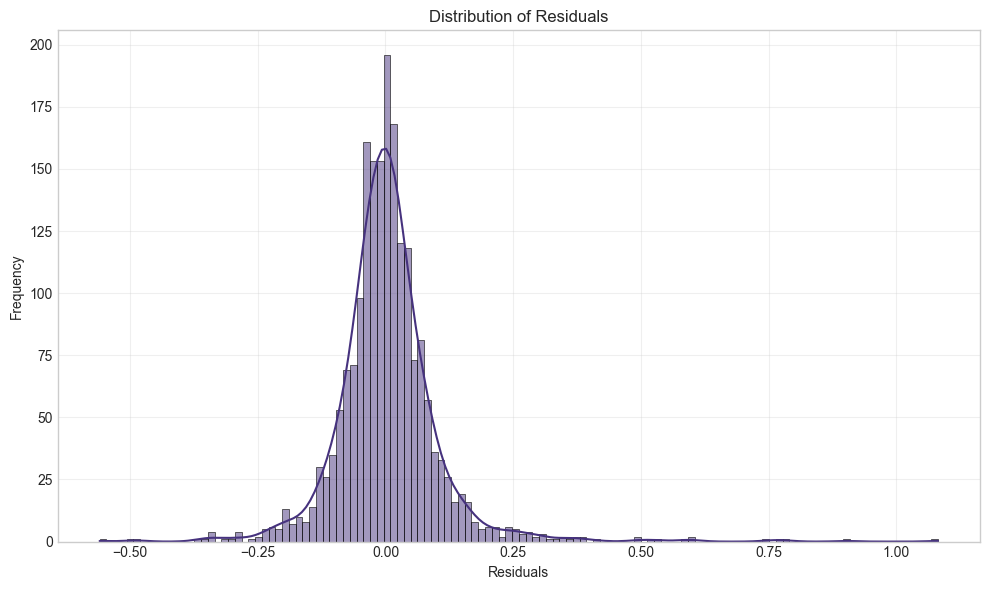

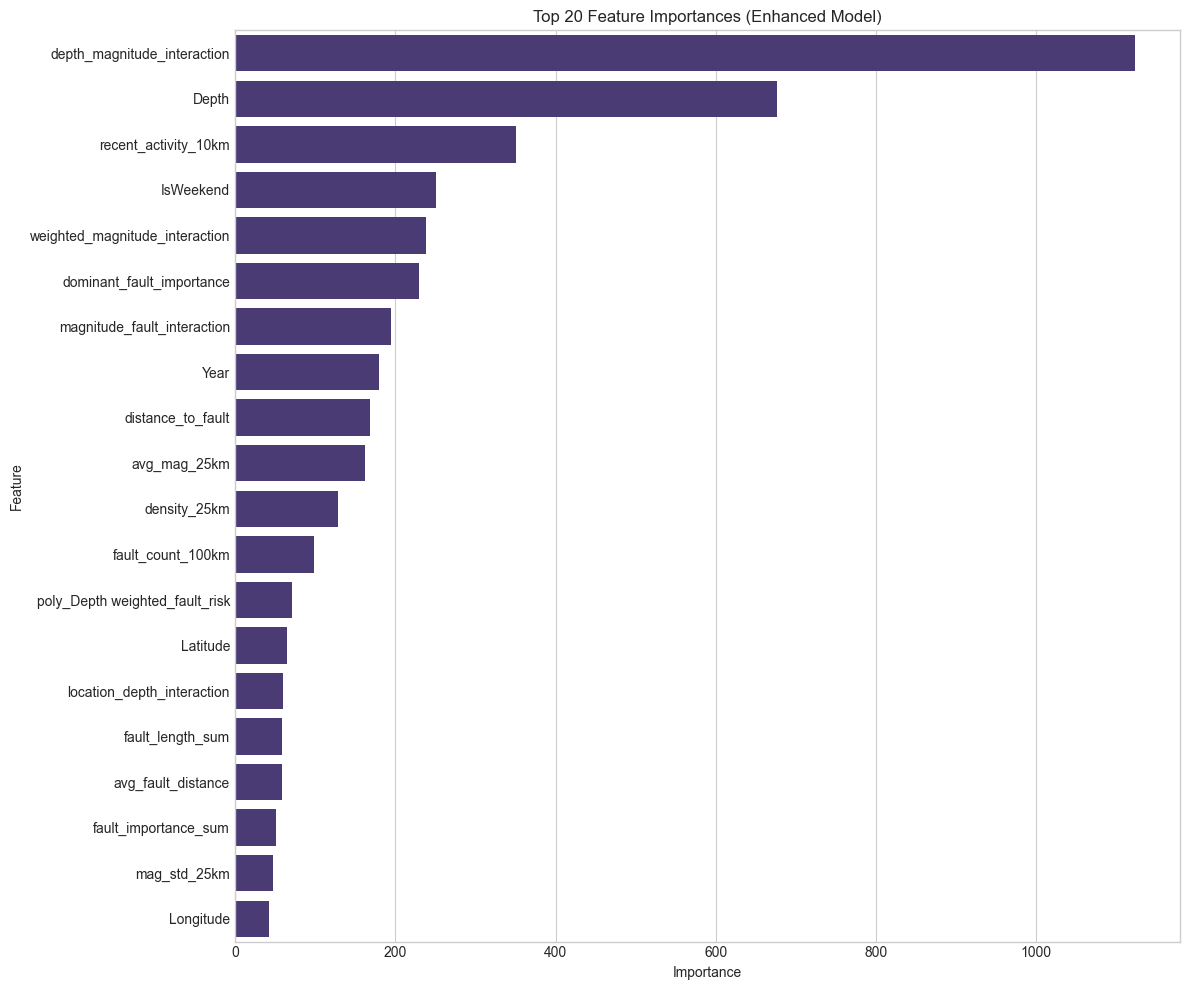

Top 15 most important features:
                           Feature  Importance
57     depth_magnitude_interaction        1123
2                            Depth         676
31            recent_activity_10km         351
9                        IsWeekend         251
68  weighted_magnitude_interaction         239
24       dominant_fault_importance         230
67     magnitude_fault_interaction         195
3                             Year         180
62               distance_to_fault         168
33                    avg_mag_25km         162
32                    density_25km         129
22               fault_count_100km          99
64  poly_Depth weighted_fault_risk          71
1                         Latitude          65
58      location_depth_interaction          60

Feature importance by category:
Fault-related features: 1088.000 total importance
Spatial density features: 638.000 total importance
Temporal features: 817.000 total importance
Interaction features: 1795.000 total i

In [13]:
# Enhanced Model Evaluation and Interpretation
print("Evaluating enhanced model...")

# Visualize actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Magnitude')
plt.ylabel('Predicted Magnitude')
plt.title('Enhanced Model: Actual vs Predicted Earthquake Magnitude')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Magnitude')
plt.ylabel('Residuals')
plt.title('Enhanced Model: Residual Plot')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Analyze residual distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Enhanced feature importance analysis
try:
    # Extract the model component from the pipeline
    model_component = best_pipeline.named_steps['model']
    
    # Check if it has feature importances
    if hasattr(model_component, 'feature_importances_'):
        # Get feature names after preprocessing
        if 'feature_selection' in best_pipeline.named_steps:
            # If feature selection was used, get selected features
            feature_selector = best_pipeline.named_steps['feature_selection']
            selected_mask = feature_selector.get_support()
            selected_features = [features[i] for i in range(len(features)) if selected_mask[i]]
            
            # Create DataFrame of feature importances for selected features
            feature_importance = pd.DataFrame({
                'Feature': selected_features,
                'Importance': model_component.feature_importances_
            }).sort_values('Importance', ascending=False)
        else:
            # No feature selection, use all features
            feature_importance = pd.DataFrame({
                'Feature': features,
                'Importance': model_component.feature_importances_
            }).sort_values('Importance', ascending=False)
        
        # Visualize top feature importances
        plt.figure(figsize=(12, 10))
        top_features = feature_importance.head(20)
        sns.barplot(x='Importance', y='Feature', data=top_features)
        plt.title('Top 20 Feature Importances (Enhanced Model)')
        plt.tight_layout()
        plt.show()
        
        print("Top 15 most important features:")
        print(feature_importance.head(15))
        
        # Analyze feature categories
        print("\nFeature importance by category:")
        fault_features = feature_importance[feature_importance['Feature'].str.contains('fault|distance', case=False, na=False)]
        spatial_features = feature_importance[feature_importance['Feature'].str.contains('density|spatial|mag_', case=False, na=False)]
        temporal_features = feature_importance[feature_importance['Feature'].str.contains('month|day|year|time|activity', case=False, na=False)]
        interaction_features = feature_importance[feature_importance['Feature'].str.contains('interaction|poly|complexity', case=False, na=False)]
        
        print(f"Fault-related features: {fault_features['Importance'].sum():.3f} total importance")
        print(f"Spatial density features: {spatial_features['Importance'].sum():.3f} total importance")
        print(f"Temporal features: {temporal_features['Importance'].sum():.3f} total importance")
        print(f"Interaction features: {interaction_features['Importance'].sum():.3f} total importance")
        
except Exception as e:
    print(f"Could not extract feature importances: {e}")

# Performance comparison with original baseline
print(f"\nEnhanced Model Performance Summary:")
print(f"RMSE: {final_rmse:.4f}")
print(f"R²: {final_r2:.4f}")
print(f"MAE: {final_mae:.4f}")

# Save the enhanced pipeline
import joblib
joblib.dump(best_pipeline, 'models/enhanced_earthquake_pipeline.pkl')
print("Enhanced pipeline saved as 'models/enhanced_earthquake_pipeline.pkl'")

# Save the enhanced dataset
model_df.to_csv('produced_data/enhanced_earthquake_data.csv', index=False)
print("Enhanced data saved as 'produced_data/enhanced_earthquake_data.csv'")

## GPU Acceleration Setup with PyTorch

Setting up GPU-accelerated deep learning using PyTorch to explore whether neural networks can capture additional patterns beyond traditional ML. This implements the bonus GPU requirement.

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time
import numpy as np
from sklearn.preprocessing import StandardScaler

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Enhanced Neural Network architecture for earthquake prediction
class EnhancedEarthquakeNN(nn.Module):
    def __init__(self, input_size):
        super(EnhancedEarthquakeNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.network(x)

Using device: cuda
PyTorch version: 2.5.1+cu121
CUDA version: 12.1
GPU: NVIDIA GeForce RTX 4070 Laptop GPU


## PyTorch Data Preparation

Preparing our enhanced feature set for GPU-accelerated training, including proper tensor conversion and data loading for efficient batch processing.

In [15]:
# Prepare enhanced data for PyTorch
X_torch = X.copy()

# Scale the features
scaler_torch = StandardScaler()
X_scaled = scaler_torch.fit_transform(X_torch)

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X_scaled)
y_tensor = torch.FloatTensor(y.values.reshape(-1, 1))

# Create train/test split - use the same proportions but create fresh tensors
X_train_tensor = torch.FloatTensor(scaler_torch.transform(X_train))
y_train_tensor = torch.FloatTensor(y_train.values.reshape(-1, 1))
X_test_tensor = torch.FloatTensor(scaler_torch.transform(X_test))
y_test_tensor = torch.FloatTensor(y_test.values.reshape(-1, 1))

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 128  # Increased batch size for enhanced features
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")
print(f"Feature dimensions: {X_train.shape[1]}")

# Initialize enhanced PyTorch model, loss function and optimizer
model = EnhancedEarthquakeNN(input_size=X_train.shape[1])
model = model.to(device)  # Move model to GPU if available

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

Training samples: 7863
Testing samples: 1966
Feature dimensions: 69


## Enhanced PyTorch Training

Training a deep neural network with advanced techniques including early stopping, learning rate scheduling, and regularization. This demonstrates the performance potential of GPU-accelerated learning.

In [16]:
# Enhanced PyTorch training function
def train_and_evaluate_enhanced():
    epochs = 150
    best_val_loss = float('inf')
    patience = 15
    counter = 0
    
    train_losses = []
    val_losses = []
    
    # Record training time
    start_time = time.time()
    
    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        train_loss = running_loss / len(train_dataset)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
        
        val_loss = val_loss / len(test_dataset)
        val_losses.append(val_loss)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            # Save best model
            torch.save(model.state_dict(), 'models/best_enhanced_pytorch_model.pt')
        else:
            counter += 1
        
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        if (epoch+1) % 20 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")
    
    # Load best model
    model.load_state_dict(torch.load('models/best_enhanced_pytorch_model.pt'))
    
    # Calculate total training time
    training_time = time.time() - start_time
    print(f"Enhanced training completed in {training_time:.2f} seconds")
    
    return train_losses, val_losses, training_time

# Run enhanced training
train_losses, val_losses, gpu_training_time = train_and_evaluate_enhanced()

Epoch 20/150, Train Loss: 0.1212, Val Loss: 0.0523, LR: 0.001000
Epoch 40/150, Train Loss: 0.0840, Val Loss: 0.0232, LR: 0.001000
Epoch 60/150, Train Loss: 0.0609, Val Loss: 0.0152, LR: 0.000250
Epoch 80/150, Train Loss: 0.0546, Val Loss: 0.0121, LR: 0.000063
Epoch 100/150, Train Loss: 0.0523, Val Loss: 0.0110, LR: 0.000008
Early stopping at epoch 114
Enhanced training completed in 25.25 seconds


C:\Users\Sarp Can\AppData\Local\Temp\ipykernel_8424\1892277239.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/best_enhanced_py

## PyTorch Evaluation and Performance Comparison

Final evaluation comparing our GPU-accelerated neural network against traditional ML approaches. This provides insights into when deep learning offers advantages for geological prediction tasks.

**Performance Analysis:**
- Comparison of training times (CPU vs GPU)
- Model accuracy comparison
- Insights on complexity vs. performance trade-offs

Enhanced PyTorch Neural Network Results:
MAE: 0.0691
RMSE: 0.1008
R²: 0.9524


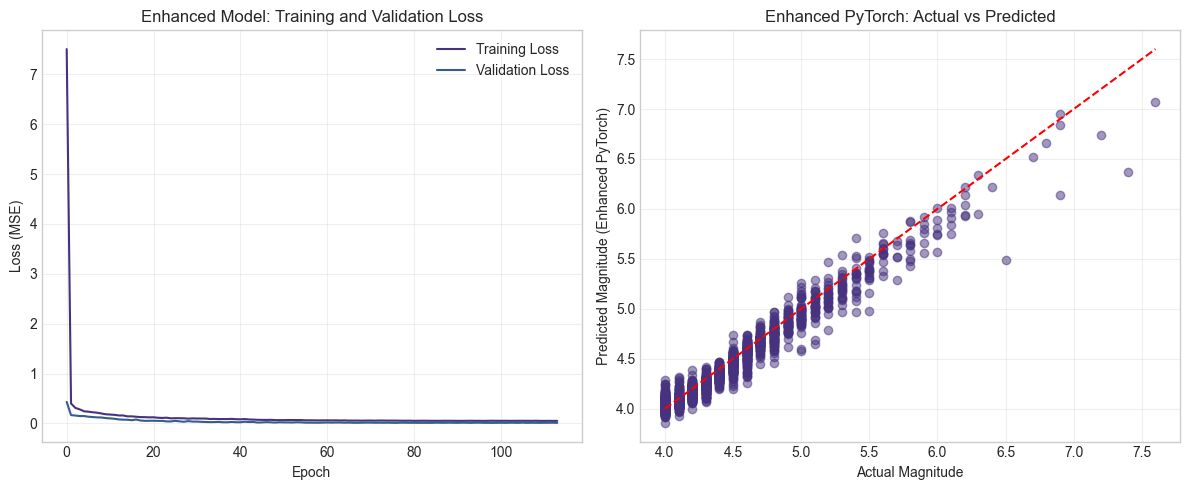


Enhanced Model Performance Comparison:
                       Model       MAE      RMSE        R²  Training Time (s)
0  Enhanced PyTorch NN (GPU)  0.069071  0.100820  0.952419          25.249837
1    Enhanced LightGBM (CPU)  0.064509  0.103151  0.950193                NaN

Performance Analysis:
Enhanced PyTorch R²: 0.9524
Enhanced LightGBM R²: 0.9502
PyTorch improvement: +0.23%
Enhanced PyTorch model and scaler saved


In [17]:
# Enhanced PyTorch model evaluation
def evaluate_enhanced_model():
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    
    # Concatenate all predictions and targets
    y_pred_torch = np.vstack(all_preds).flatten()
    y_test_torch = np.vstack(all_targets).flatten()
    
    # Calculate metrics
    torch_mae = mean_absolute_error(y_test_torch, y_pred_torch)
    torch_rmse = np.sqrt(mean_squared_error(y_test_torch, y_pred_torch))
    torch_r2 = r2_score(y_test_torch, y_pred_torch)
    
    print(f"Enhanced PyTorch Neural Network Results:")
    print(f"MAE: {torch_mae:.4f}")
    print(f"RMSE: {torch_rmse:.4f}")
    print(f"R²: {torch_r2:.4f}")
    
    return torch_mae, torch_rmse, torch_r2, y_pred_torch

# Evaluate enhanced model
torch_mae, torch_rmse, torch_r2, y_pred_torch = evaluate_enhanced_model()

# Plot enhanced training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Enhanced Model: Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_torch, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Magnitude')
plt.ylabel('Predicted Magnitude (Enhanced PyTorch)')
plt.title('Enhanced PyTorch: Actual vs Predicted')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Enhanced model comparison
comparison_data = {
    'Model': ['Enhanced PyTorch NN (GPU)', f'Enhanced {best_model_name} (CPU)'],
    'MAE': [torch_mae, final_mae],
    'RMSE': [torch_rmse, final_rmse],
    'R²': [torch_r2, final_r2],
    'Training Time (s)': [gpu_training_time, None]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nEnhanced Model Performance Comparison:")
print(comparison_df)

# Performance improvement analysis
print(f"\nPerformance Analysis:")
print(f"Enhanced PyTorch R²: {torch_r2:.4f}")
print(f"Enhanced {best_model_name} R²: {final_r2:.4f}")
if torch_r2 > final_r2:
    improvement = ((torch_r2 - final_r2) / final_r2) * 100
    print(f"PyTorch improvement: +{improvement:.2f}%")
else:
    reduction = ((final_r2 - torch_r2) / final_r2) * 100
    print(f"Traditional ML advantage: +{reduction:.2f}%")

# Save enhanced PyTorch model components
torch.save(model.state_dict(), 'models/enhanced_earthquake_pytorch_model.pt')
joblib.dump(scaler_torch, 'models/enhanced_pytorch_scaler.pkl')
print("Enhanced PyTorch model and scaler saved")

In [18]:
# Enhanced Geographic Visualization
# Create a map centered on Turkey with enhanced features
turkey_map = folium.Map(location=[38.5, 35.5], zoom_start=6)

# Sample points for better visualization performance
sample_df = model_df.sample(min(2000, len(model_df)))

# Create a heatmap layer with enhanced risk data
heat_data = [[row['Latitude'], row['Longitude'], row.get('weighted_fault_risk', 1)] for index, row in sample_df.iterrows()]
HeatMap(heat_data, radius=8, gradient={'0.4': 'blue', '0.6': 'cyan', '0.8': 'yellow', '1.0': 'red'}).add_to(turkey_map)

# Add markers for strong earthquakes (magnitude > 6) with enhanced info
for idx, row in model_df[model_df['Magnitude'] > 6].iterrows():
    # Enhanced popup content with new features
    popup_content = f"""
    <div style="font-family: Arial; min-width: 250px;">
        <h4 style="margin-bottom: 5px; color: #d32f2f;">Enhanced Earthquake Details</h4>
        <b>Magnitude:</b> {row['Magnitude']:.1f}<br>
        <b>Depth:</b> {row['Depth']:.1f} km<br>
        <b>Date:</b> {row['Date']}<br>
        <b>Location:</b> {row['Location']}<br>
        <hr>
        <b>Enhanced Features:</b><br>
        <b>Weighted Fault Risk:</b> {row.get('weighted_fault_risk', 'N/A')}<br>
        <b>Fault Count (100km):</b> {row.get('fault_count_100km', 'N/A')}<br>
        <b>Spatial Density (50km):</b> {row.get('density_50km', 'N/A')}<br>
        <b>Complexity Score:</b> {row.get('fault_complexity_score', 'N/A')}<br>
    </div>
    """
    
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=row['Magnitude'] * 1.5,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        popup=folium.Popup(popup_content, max_width=350),
    ).add_to(turkey_map)

# Add fault lines to the map
def add_faults_to_map(map_obj, fault_gdf, importance_threshold=0):
    if importance_threshold > 0:
        fault_data = fault_gdf[fault_gdf['importance'] >= importance_threshold]
    else:
        fault_data = fault_gdf
    
    def style_function(feature):
        importance = feature['properties']['importance']
        color = '#FF0000' if importance >= 4 else '#FFA500' if importance >= 3 else '#FFFF00'
        return {
            'color': color,
            'weight': importance * 0.5,
            'opacity': 0.7
        }
    
    folium.GeoJson(
        fault_data,
        name='Fault Lines',
        style_function=style_function,
        tooltip=folium.GeoJsonTooltip(fields=['FAULT_NAME', 'importance']),
    ).add_to(map_obj)
    
    return map_obj

# Add fault lines
turkey_map = add_faults_to_map(turkey_map, fault_gdf, importance_threshold=3)

# Enhanced legend
legend_html = '''
<div style="position: fixed; bottom: 20px; right: 20px; width: 250px; height: auto; 
    background-color: white; border:2px solid grey; z-index:9999; font-size:12px;
    padding: 10px; border-radius: 5px;">
    <p><b>Enhanced Earthquake Map</b></p>
    <p><i class="fa fa-circle" style="color:red"></i> Magnitude > 6</p>
    <div style="margin-top:5px;">
      <p><b>Heatmap:</b> Weighted Fault Risk</p>
      <div style="display:inline-block; height:15px; width:30px; background:blue;"></div>
      <div style="display:inline-block; height:15px; width:30px; background:cyan;"></div>
      <div style="display:inline-block; height:15px; width:30px; background:yellow;"></div>
      <div style="display:inline-block; height:15px; width:30px; background:red;"></div>
      <p style="font-size:10px;">Low Risk → High Risk</p>
    </div>
    <div style="margin-top:5px;">
      <p><b>Fault Importance:</b></p>
      <p><span style="color:#FF0000;">━━━</span> High (4+)</p>
      <p><span style="color:#FFA500;">━━━</span> Medium (3)</p>
      <p><span style="color:#FFFF00;">━━━</span> Low (<3)</p>
    </div>
</div>
'''
turkey_map.get_root().html.add_child(folium.Element(legend_html))

# Add layer control
folium.LayerControl().add_to(turkey_map)

# Save enhanced map
turkey_map.save('maps/enhanced_earthquake_map.html')
print("Enhanced earthquake map saved to 'maps/enhanced_earthquake_map.html'")

Enhanced earthquake map saved to 'maps/enhanced_earthquake_map.html'


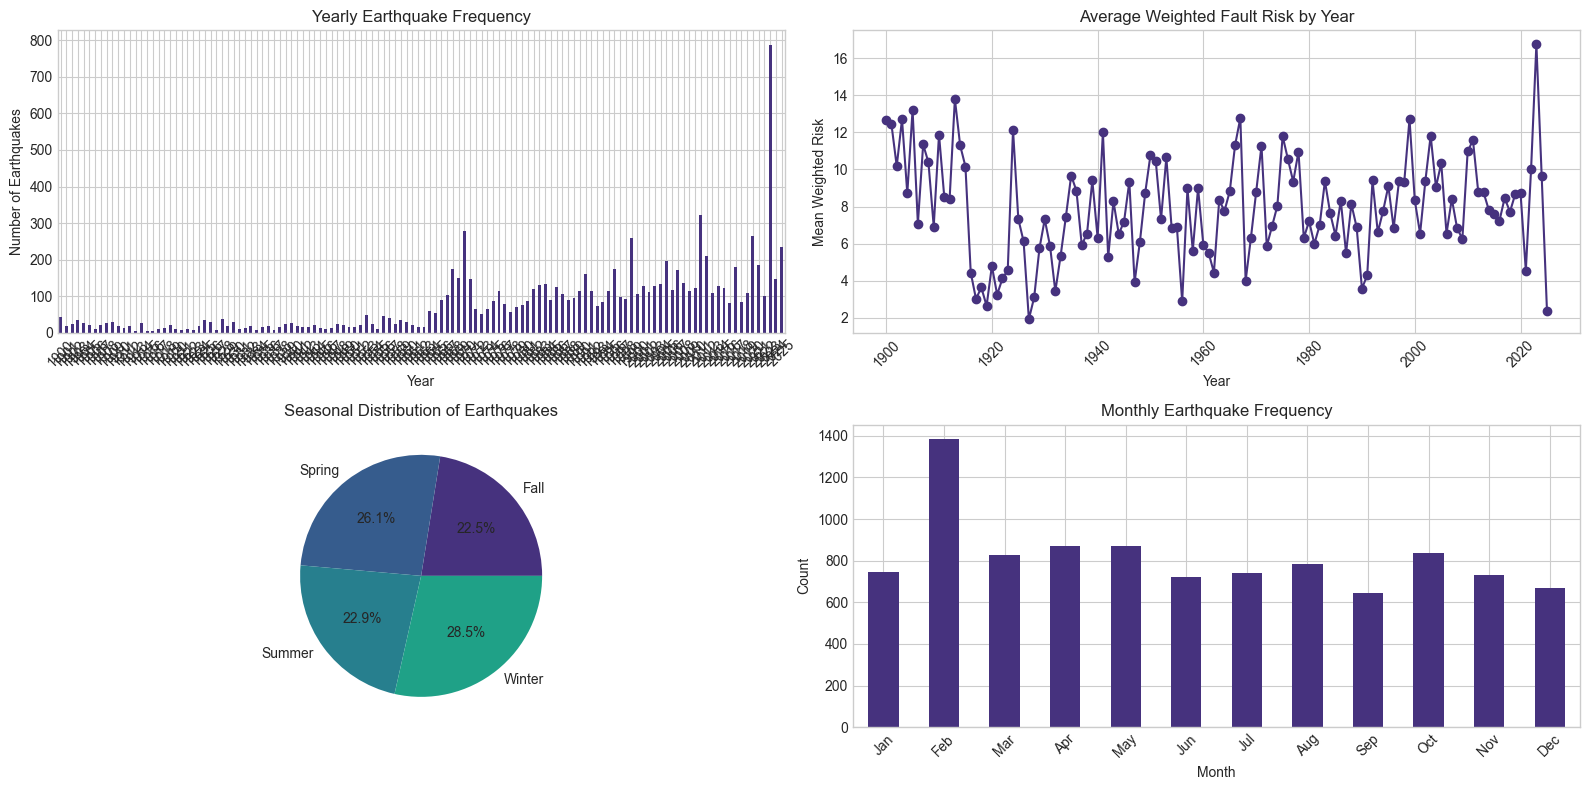

Enhanced yearly statistics:
      Count  Mean_Mag  Max_Mag  Mean_Risk  Mean_Complexity
Year                                                      
1900     43     4.623      5.9     12.675            2.878
1901     19     4.963      6.1     12.436            2.442
1902     24     4.837      5.7     10.178            2.225
1903     34     4.812      6.3     12.694            2.156
1904     28     4.800      6.2      8.708            2.790
1905     23     5.204      6.8     13.202            2.719
1906     10     4.930      6.2      7.074            1.826
1907     22     4.732      5.5     11.343            2.125
1908     27     4.715      6.1     10.381            2.301
1909     30     5.033      6.4      6.926            2.085


In [19]:
# Enhanced Temporal Analysis with new features
# Yearly earthquake frequency with enhanced risk metrics
yearly_analysis = model_df.groupby('Year').agg({
    'Magnitude': ['count', 'mean', 'max'],
    'weighted_fault_risk': 'mean',
    'fault_complexity_score': 'mean'
}).round(3)

yearly_analysis.columns = ['Count', 'Mean_Mag', 'Max_Mag', 'Mean_Risk', 'Mean_Complexity']

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
yearly_analysis['Count'].plot(kind='bar')
plt.title('Yearly Earthquake Frequency')
plt.ylabel('Number of Earthquakes')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
yearly_analysis['Mean_Risk'].plot(kind='line', marker='o')
plt.title('Average Weighted Fault Risk by Year')
plt.ylabel('Mean Weighted Risk')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
seasonal_enhanced = model_df.groupby('Season').agg({
    'Magnitude': 'count',
    'weighted_fault_risk': 'mean',
    'density_50km': 'mean'
})
seasonal_enhanced['Magnitude'].plot(kind='pie', autopct='%1.1f%%')
plt.title('Seasonal Distribution of Earthquakes')
plt.ylabel('')

plt.subplot(2, 2, 4)
monthly_enhanced = model_df.groupby('Month').agg({
    'Magnitude': 'count',
    'fault_complexity_score': 'mean'
})
monthly_enhanced['Magnitude'].plot(kind='bar')
plt.title('Monthly Earthquake Frequency')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)

plt.tight_layout()
plt.show()

print("Enhanced yearly statistics:")
print(yearly_analysis.head(10))

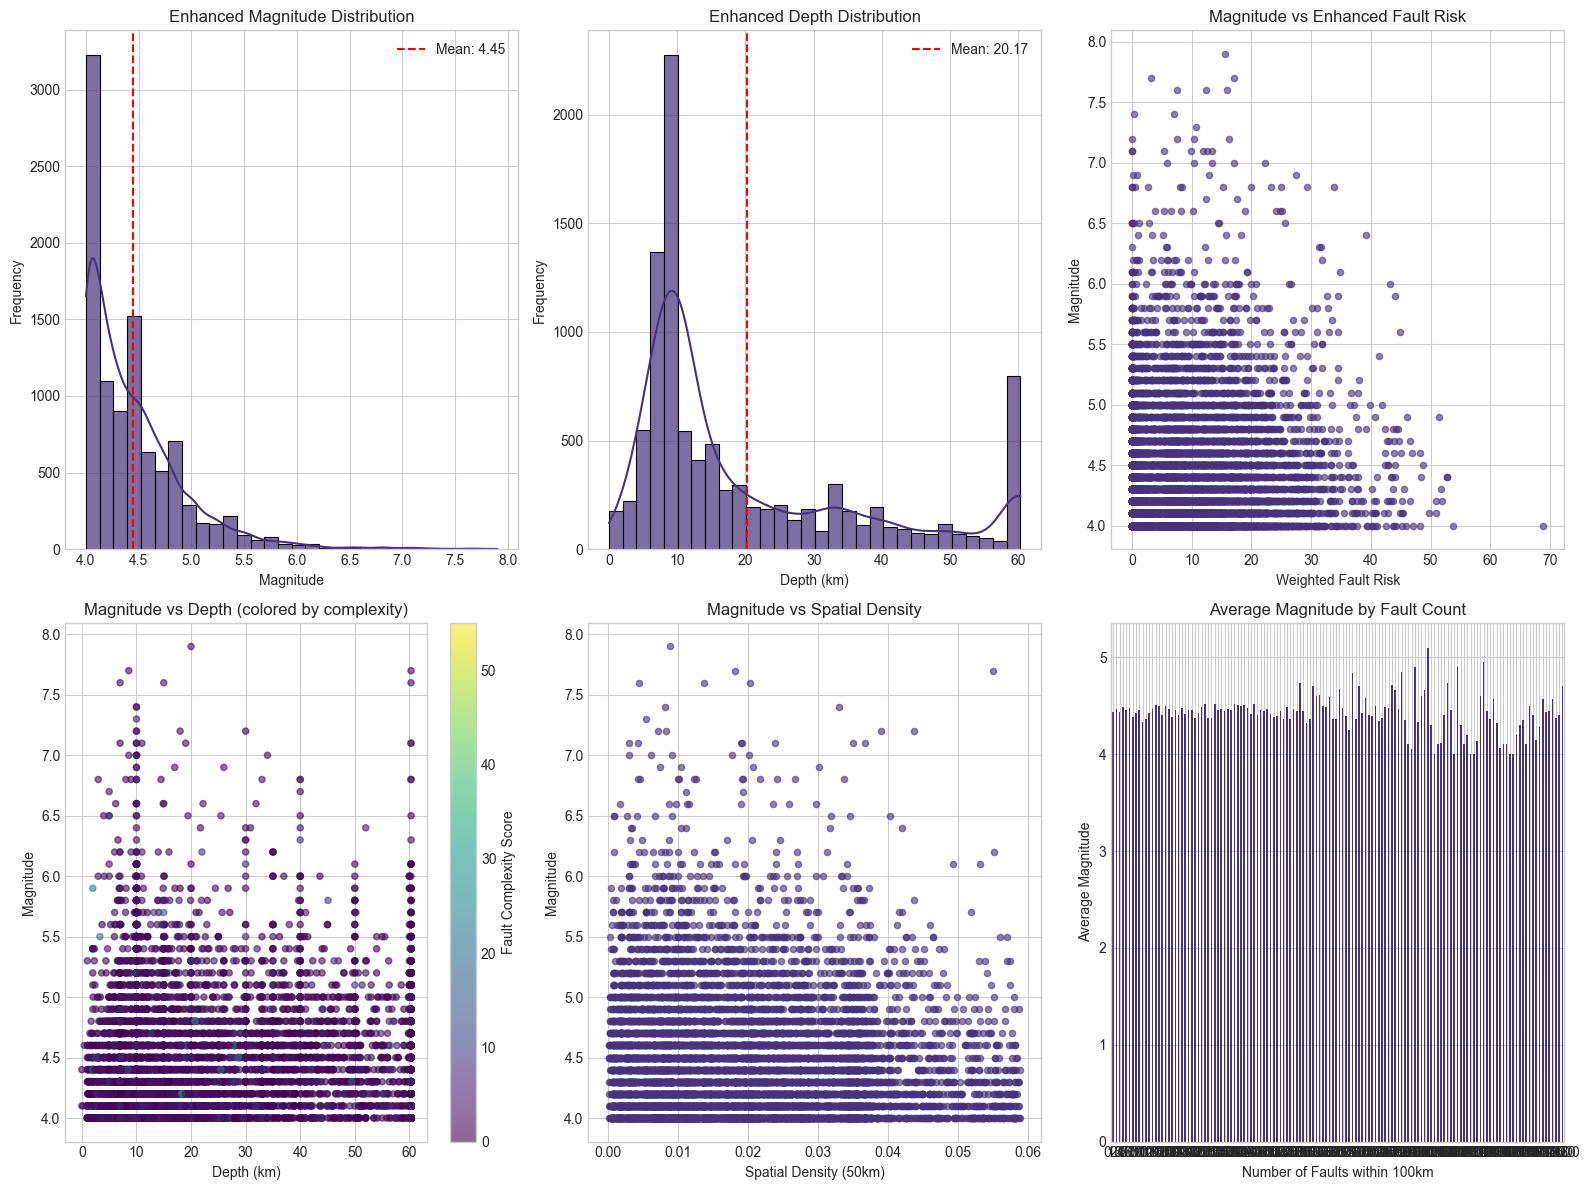

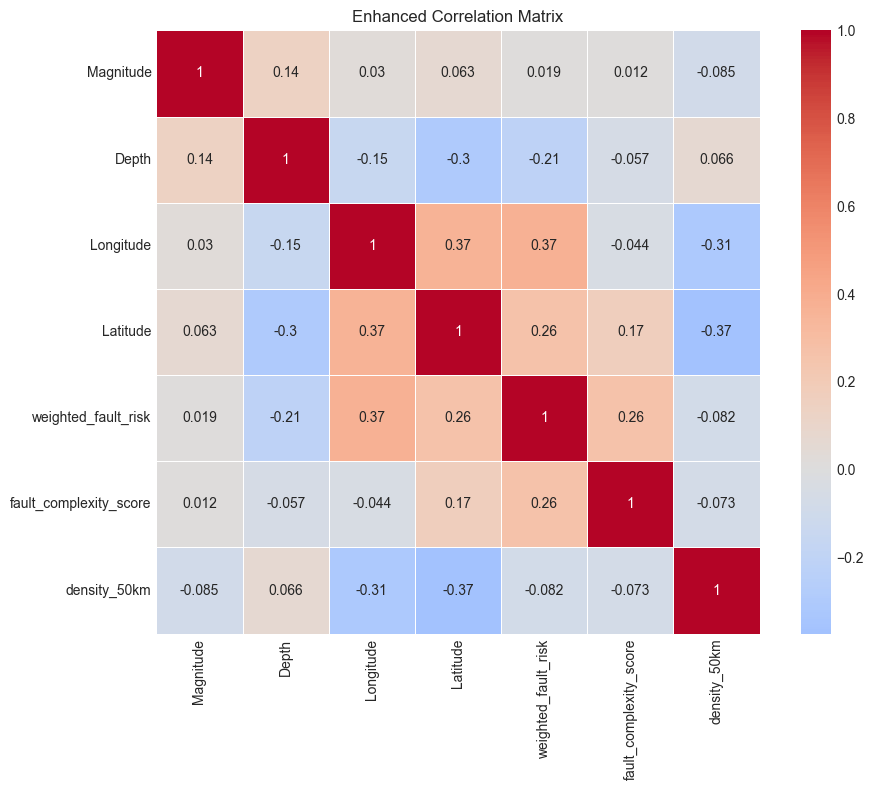

In [20]:
# Enhanced Magnitude and Depth Analysis
plt.figure(figsize=(16, 12))

# Enhanced magnitude distribution with risk overlay
plt.subplot(2, 3, 1)
sns.histplot(model_df['Magnitude'], bins=30, kde=True, alpha=0.7)
plt.axvline(model_df['Magnitude'].mean(), color='red', linestyle='--', 
           label=f'Mean: {model_df["Magnitude"].mean():.2f}')
plt.title('Enhanced Magnitude Distribution')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.legend()

# Enhanced depth distribution
plt.subplot(2, 3, 2)
sns.histplot(model_df['Depth'], bins=30, kde=True, alpha=0.7)
plt.axvline(model_df['Depth'].mean(), color='red', linestyle='--', 
           label=f'Mean: {model_df["Depth"].mean():.2f}')
plt.title('Enhanced Depth Distribution')
plt.xlabel('Depth (km)')
plt.ylabel('Frequency')
plt.legend()

# Magnitude vs enhanced fault risk
plt.subplot(2, 3, 3)
if 'weighted_fault_risk' in model_df.columns:
    plt.scatter(model_df['weighted_fault_risk'], model_df['Magnitude'], alpha=0.6, s=20)
    plt.xlabel('Weighted Fault Risk')
    plt.ylabel('Magnitude')
    plt.title('Magnitude vs Enhanced Fault Risk')
else:
    plt.text(0.5, 0.5, 'Weighted Fault Risk\nNot Available', ha='center', va='center')
    plt.title('Enhanced Feature Not Available')

# Enhanced relationship between magnitude and depth with fault complexity
plt.subplot(2, 3, 4)
if 'fault_complexity_score' in model_df.columns:
    scatter = plt.scatter(model_df['Depth'], model_df['Magnitude'], 
                         c=model_df['fault_complexity_score'], cmap='viridis', alpha=0.6, s=20)
    plt.colorbar(scatter, label='Fault Complexity Score')
    plt.xlabel('Depth (km)')
    plt.ylabel('Magnitude')
    plt.title('Magnitude vs Depth (colored by complexity)')
else:
    plt.scatter(model_df['Depth'], model_df['Magnitude'], alpha=0.6, s=20)
    plt.xlabel('Depth (km)')
    plt.ylabel('Magnitude')
    plt.title('Magnitude vs Depth')

# Spatial density analysis
plt.subplot(2, 3, 5)
if 'density_50km' in model_df.columns:
    plt.scatter(model_df['density_50km'], model_df['Magnitude'], alpha=0.6, s=20)
    plt.xlabel('Spatial Density (50km)')
    plt.ylabel('Magnitude')
    plt.title('Magnitude vs Spatial Density')
else:
    plt.text(0.5, 0.5, 'Spatial Density\nNot Available', ha='center', va='center')
    plt.title('Enhanced Feature Not Available')

# Multi-fault risk distribution
plt.subplot(2, 3, 6)
if 'fault_count_100km' in model_df.columns:
    fault_count_analysis = model_df.groupby('fault_count_100km')['Magnitude'].mean()
    fault_count_analysis.plot(kind='bar')
    plt.xlabel('Number of Faults within 100km')
    plt.ylabel('Average Magnitude')
    plt.title('Average Magnitude by Fault Count')
    plt.xticks(rotation=0)
else:
    plt.text(0.5, 0.5, 'Fault Count\nNot Available', ha='center', va='center')
    plt.title('Enhanced Feature Not Available')

plt.tight_layout()
plt.show()

# Enhanced correlation analysis
correlation_subset = ['Magnitude', 'Depth', 'Longitude', 'Latitude']
if 'weighted_fault_risk' in model_df.columns:
    correlation_subset.extend(['weighted_fault_risk', 'fault_complexity_score', 'density_50km'])

correlation_matrix = model_df[correlation_subset].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Enhanced Correlation Matrix')
plt.tight_layout()
plt.show()

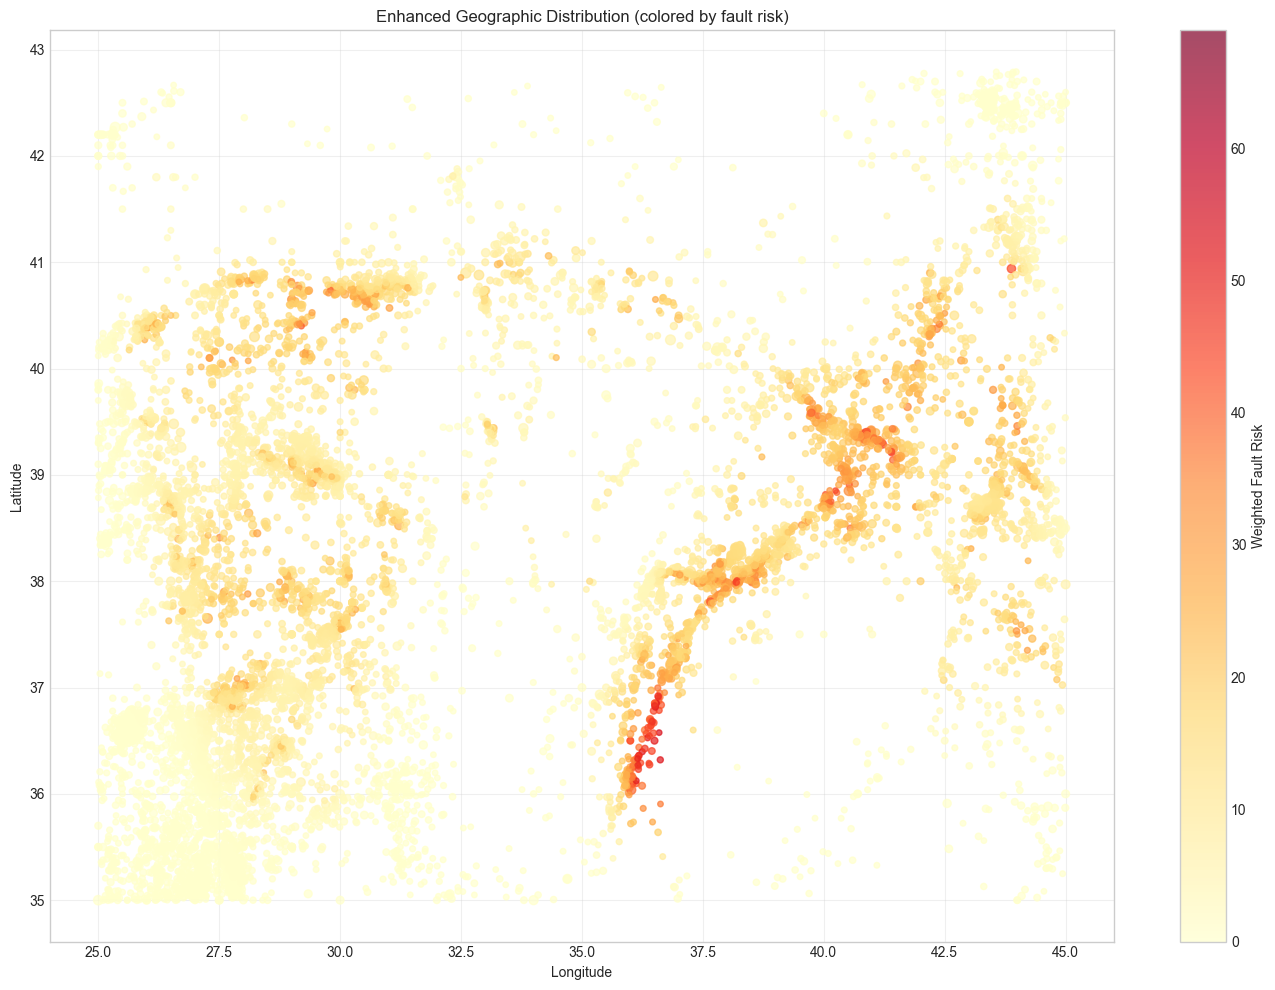

C:\Users\Sarp Can\AppData\Local\Temp\ipykernel_8424\797758656.py:54: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



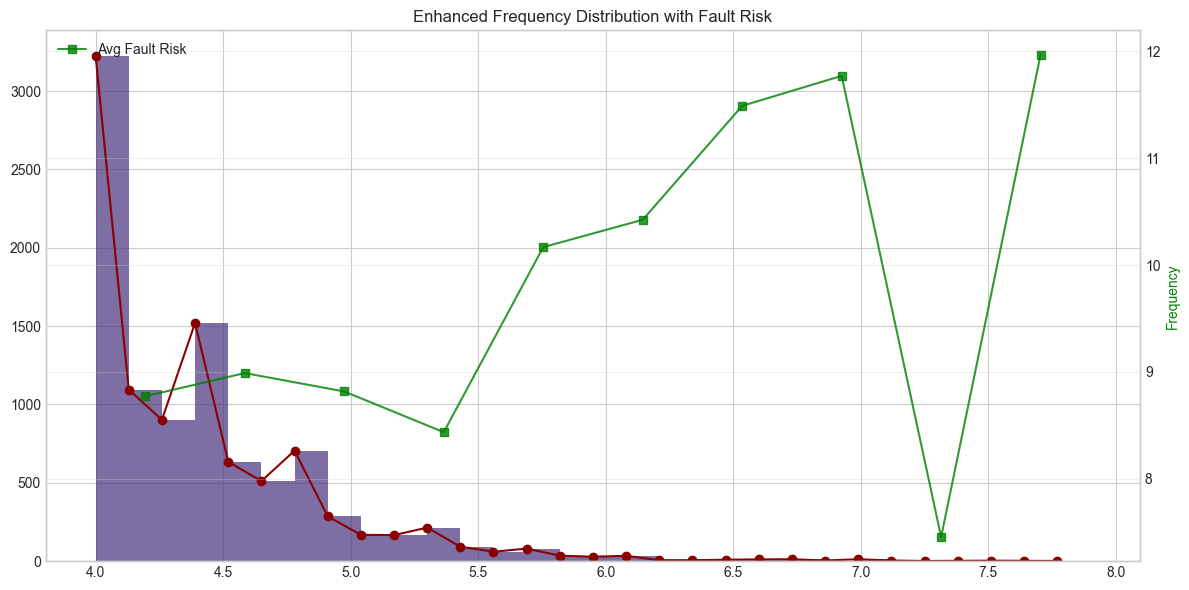

C:\Users\Sarp Can\AppData\Local\Temp\ipykernel_8424\797758656.py:77: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



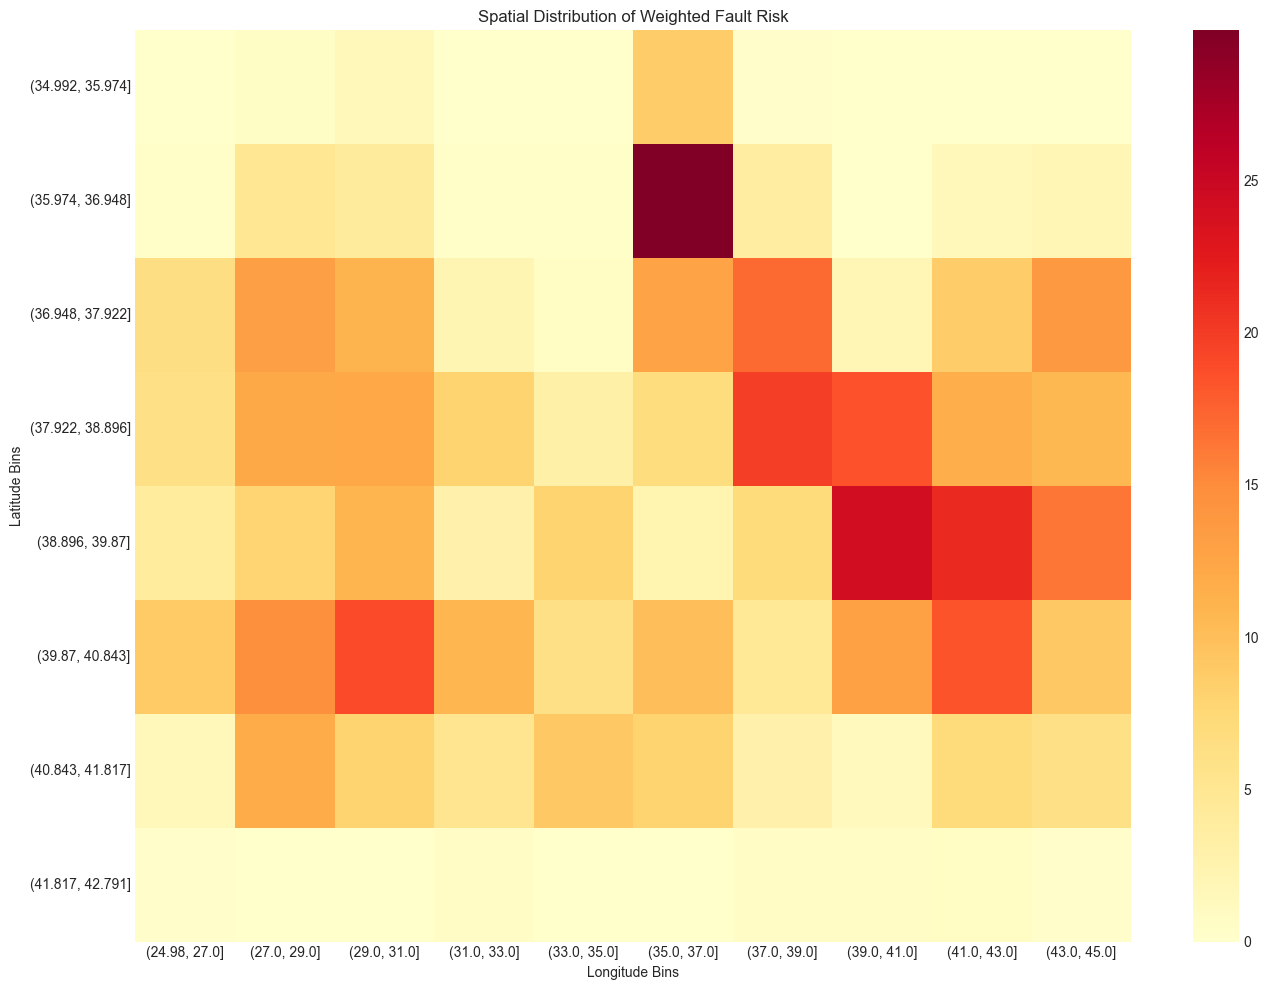

Enhanced 3D visualization saved to 'maps/enhanced_earthquake_3d.html'


In [21]:
# Enhanced 3D visualization with Plotly
import plotly.express as px

# 3D scatter plot with enhanced features
fig = px.scatter_3d(
    model_df.sample(min(3000, len(model_df))), 
    x='Longitude', y='Latitude', z='Depth',
    color='weighted_fault_risk' if 'weighted_fault_risk' in model_df.columns else 'Magnitude',
    size='Magnitude',
    color_continuous_scale='Viridis',
    title='Enhanced 3D Visualization of Earthquakes',
    hover_data=['fault_complexity_score', 'density_50km'] if 'fault_complexity_score' in model_df.columns else ['Magnitude']
)

fig.update_layout(scene=dict(
    xaxis_title='Longitude',
    yaxis_title='Latitude',
    zaxis_title='Depth (km)',
    zaxis=dict(autorange="reversed")
))
fig.write_html('maps/enhanced_earthquake_3d.html')
fig.show()

# Enhanced geographic distribution by magnitude with fault risk
plt.figure(figsize=(14, 10))
if 'weighted_fault_risk' in model_df.columns:
    scatter = plt.scatter(model_df['Longitude'], model_df['Latitude'], 
                         c=model_df['weighted_fault_risk'], cmap='YlOrRd', 
                         alpha=0.7, s=model_df['Magnitude']**2)
    plt.colorbar(scatter, label='Weighted Fault Risk')
    plt.title('Enhanced Geographic Distribution (colored by fault risk)')
else:
    scatter = plt.scatter(model_df['Longitude'], model_df['Latitude'], 
                         c=model_df['Magnitude'], cmap='YlOrRd', 
                         alpha=0.7, s=model_df['Magnitude']**2)
    plt.colorbar(scatter, label='Magnitude')
    plt.title('Geographic Distribution by Magnitude')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Enhanced magnitude frequency plot with fault risk overlay
plt.figure(figsize=(12, 6))
counts, bins, _ = plt.hist(model_df['Magnitude'], bins=30, alpha=0.7, label='Frequency')
plt.plot(bins[:-1], counts, '-o', color='darkred')

# Add average fault risk by magnitude bin if available
if 'weighted_fault_risk' in model_df.columns:
    ax2 = plt.twinx()
    mag_bins = pd.cut(model_df['Magnitude'], bins=10)
    risk_by_mag = model_df.groupby(mag_bins)['weighted_fault_risk'].mean()
    ax2.plot(risk_by_mag.index.map(lambda x: x.mid), risk_by_mag.values, 
             'g-s', alpha=0.8, label='Avg Fault Risk')
    ax2.set_ylabel('Average Weighted Fault Risk', color='green')
    ax2.legend(loc='upper right')

plt.title('Enhanced Frequency Distribution with Fault Risk')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Heatmap of enhanced features by location
if all(col in model_df.columns for col in ['weighted_fault_risk', 'fault_complexity_score']):
    plt.figure(figsize=(14, 10))
    
    # Create location bins for heatmap
    lat_bins = pd.cut(model_df['Latitude'], bins=8)
    lon_bins = pd.cut(model_df['Longitude'], bins=10)
    
    # Calculate mean risk by location
    location_risk = model_df.groupby([lat_bins, lon_bins])['weighted_fault_risk'].mean().unstack()
    
    sns.heatmap(location_risk, cmap='YlOrRd', annot=False, fmt='.1f')
    plt.title('Spatial Distribution of Weighted Fault Risk')
    plt.xlabel('Longitude Bins')
    plt.ylabel('Latitude Bins')
    plt.tight_layout()
    plt.show()

print("Enhanced 3D visualization saved to 'maps/enhanced_earthquake_3d.html'")